In [77]:
import sys
import numpy as np
import deepdish as dd
import os
import h5py
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from _classification_util import (GetTemplates, GetTaskTimeseries, Get_xTrain_yTrain,
                                  TrainClassifier, GetTransitionsFromEventMat,
                                  Get_xTest_yTest, RunClassifier, GetPairedEventMat,
                                  Convert_SourceItem_to_PairedItem_Order)
                                  
from _mempal_util import (subject_ids, nSubj, GetROIVerts, create_dirs, room_obj_assignments,
                          GetTaskTSV, MakeEncodingEventMatrix, GetRecallEventInfo, MakeRecallEventMatrices,
                          PschopyRoomLabel2TranscrptionLabels,RoomObjectFileNameKey)

## for finding shortest path and visualizing adjacency matrix
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
import pylab as pylabplt
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import to_agraph 

## prepare empty df to be filled with behavior data

In [78]:

### CONSTANTS

task='ses-02_task-recall' #'ses-01_task-pathvideo'#'ses-02_task-recall'
trials = ['GR0', 'GR1', 'GR2', 'GR3', 'GR4', 'GR5', 'GR6', 'GR7','GR8','GR9','GR10','FR'] #,'FR']
event_types = ['room_events', 'object_events','object_raw_events']

nRows = nSubj*len(trials)

columns = ['subj_idx','subj','trial','cued_correct','all_correct','adjacent_travel', 'trial_time',
           
           # these will be lists
          'cued_rooms', 'rooms_recalled', 'objects_recalled', 'objects_raw_recalled','time_rooms','time_objects','time_raw_objects','trial_type']


TR = 1.3
dt = 0.1

print(columns)

### GENERATE DF
df = pd.DataFrame(np.full((nRows,len(columns)),fill_value=np.nan),columns=columns)


### CREATE labeled ROWs

subj_labels = np.repeat(subject_ids,len(trials))
subj_idx = np.repeat(range(len(subject_ids)),len(trials))
trial_labels = trials * nSubj
df['subj_idx'] = subj_idx.astype(int)
df['subj'] = subj_labels
df['trial'] = trial_labels
df = df.astype(object)
df.trial_type[df.trial.str.contains('GR')] = 'GR'
df.trial_type[np.invert(df.trial.str.contains('GR'))] = 'FR'

df

['subj_idx', 'subj', 'trial', 'cued_correct', 'all_correct', 'adjacent_travel', 'trial_time', 'cued_rooms', 'rooms_recalled', 'objects_recalled', 'objects_raw_recalled', 'time_rooms', 'time_objects', 'time_raw_objects', 'trial_type']


,subj_idx,subj,trial,cued_correct,all_correct,adjacent_travel,trial_time,cued_rooms,rooms_recalled,objects_recalled,objects_raw_recalled,time_rooms,time_objects,time_raw_objects,trial_type
0,0,sub-sid01,GR0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GR
1,0,sub-sid01,GR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GR
2,0,sub-sid01,GR2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GR
3,0,sub-sid01,GR3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GR
4,0,sub-sid01,GR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,24,sub-sid29,GR7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GR
296,24,sub-sid29,GR8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GR
297,24,sub-sid29,GR9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GR
298,24,sub-sid29,GR10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GR


## fill up df with data

In [79]:
def GetRoomsToRecall(recall_info,print_tsv=False):
    '''recall info is a dict with stimfile info'''
    if str(recall_info['stim_file'].tolist()[0]) != 'nan':
        stim_names = recall_info['stim_file'].tolist()[0] # convert to string
        stim_names = list(map(str.strip, stim_names.split(';'))) # 
        rooms_to_recall = [PschopyRoomLabel2TranscrptionLabels[room_name] for room_name in stim_names]
        ridx_to_recall = [RoomObjectFileNameKey[rooms_to_recall[i]] for i in range(len(rooms_to_recall))]
        if print_tsv:
            print(recall_info)
        return rooms_to_recall, list(np.array(ridx_to_recall)-1) #zero indexing here
    else:
        neg_return = [-1, -1, -1, -1, -1]
        return neg_return, neg_return

In [80]:



## STATS:
# average time spent talking GR per GR
# average time spent talking FR
# time spent on each room or object
# 
# correct number of room-object associations
# adjacent travel vs non-adjacent travel
# 

## time spent per trial
# trial_time = np.full((nSubj, len(trials)), fill_type=np.nan)

recall_freq = {}

count = -1
for i, subj in enumerate(subject_ids[:]):
    # for i in [23]:

#     subj = subject_ids[i] # get subj string

    print(i,subject_ids[i])

    ###
    ### FOR a TRIAL (FR or GR), CLASSIFY TIMEPOINTS
    ###

    for ti, trial in enumerate(trials[:]):
        count += 1
        
        # row index
        row_idx = (df.index[df['subj_idx'] == i] & df.index[df['trial'] == trial]).tolist()[0]


        if 'recall' in task:

            ## GET start_TR and end_TR
            cushion = 0 #int(round(TR*4)) #add 4 TRs of cushion to end_TR/ which is ~5s (peak of hrf)
            recall_info_TR = GetRecallEventInfo(MakeRecallEventMatrices(subj, task, trial, TR, False), event_types,cushion) #don't trust event_matrices from TR or lower res b/c events with less than a second disappear
            start_TR, end_TR, run_TRs = recall_info_TR['start'], recall_info_TR['end'], recall_info_TR['run_TRs']
            segment_TRs = end_TR - start_TR #we cut out segment from start to end
            
            # in seconds
            dtt = 1 #s
            recall_info = GetRecallEventInfo(MakeRecallEventMatrices(subj, task, trial, dtt, False), event_types,cushion) #don't trust event_matrices from TR or lower res b/c events with less than a second disappear
            start, end, run_TRs = recall_info_TR['start'], recall_info_TR['end'], recall_info_TR['run_TRs']

            room_events = recall_info['event_matrices']['room_events']
            object_events_bysubj = recall_info['event_matrices']['object_events'] #object indices match fixed room indeces 
            object_raw_events = recall_info['event_matrices']['object_raw_events'] #object indeces are fixed for all subjs
            object_events = recall_info['event_matrices']['object_events'] #object indices match fixed room indeces 

            #### GET ROOM-OBJECT RECALL CORRECTNESS
            ## GET ROOM / OBJECT INFORMATION
            
            # where there is a room or object entry in matrix
            room_entries = np.where(room_events==1)[1]
            object_entries = np.where(object_events==1)[1]
            object_raw_entries = np.where(object_raw_events==1)[1]

            # how much time spent in a room or talking about an object
            rooms_remembered,rooms_time = np.unique(room_entries, return_counts=True)
            objs_remembered, objects_time = np.unique(object_entries, return_counts=True)
            objs_raw_remembered, objects_raw_time = np.unique(object_raw_entries, return_counts=True)
            
            # create a dict with room/object as key and value is the time spent talking about that
            rooms_time = { k:v for (k,v) in zip(rooms_remembered, rooms_time)}  
            objects_time = { k:v for (k,v) in zip(objs_remembered, objects_time)}  
            objects_raw_time = { k:v for (k,v) in zip(objs_raw_remembered, objects_raw_time)}  

            # order of which rooms and objects were remembered
            # first_transitions,first_item_numbers,all_transitions,all_item_numbers
            rooms_remembered_ordered = GetTransitionsFromEventMat(room_events)[-1] # 20230724
            objs_remembered_ordered = GetTransitionsFromEventMat(object_events)[-1] # the -1
            objs_raw_remembered_ordered = GetTransitionsFromEventMat(object_raw_events)[-1]
            
            ### ROOMS that were CUED on screen for participant to recall objects and rooms in detail
            cue_rooms, cue_ridx = GetRoomsToRecall(recall_info) # get cued rooms

            ## THE RIGHT WAY TO DO OVERALL ACCURACY for FRs is to count the rooms they remembered and count the objects they remembered.
            all_remembered = ( len(np.unique(rooms_remembered))+len(np.unique(objs_remembered)) ) / 46
            
            cue_remembered = len(set(cue_ridx).intersection(set(objs_remembered)))/len(cue_ridx)
#             remembered = np.sum(rooms_remembered==objs_remembered)/np.max([len(rooms_remembered), len(objs_remembered)])
            print(subj,trial,cue_ridx, rooms_remembered_ordered, objs_remembered_ordered,cue_remembered)

#             print(subj,trial,rooms_remembered,objs_remembered)

            ### UPDATE DATAFRAME
            df.cued_rooms.iloc[row_idx] = cue_ridx if trial!='FR' else np.nan
            df.rooms_recalled.iloc[row_idx] = rooms_remembered_ordered
            df.objects_recalled.iloc[row_idx] = objs_remembered_ordered
            df.objects_raw_recalled.iloc[row_idx] = objs_raw_remembered_ordered
            df.all_correct.iloc[row_idx] = all_remembered
            df.cued_correct.iloc[row_idx] = cue_remembered if trial!='FR' else np.nan
            df.trial_time.iloc[row_idx] = end - start 
#             df.time_rooms.astype(object)
            df.time_rooms.iloc[row_idx] = [rooms_time]
            df.time_objects.iloc[row_idx] = [objects_time]
            df.time_raw_objects.iloc[row_idx] = [objects_raw_time]
#             df.at[df.columns.get_loc("time_objects"),row_idx] = list(objects_time)


0 sub-sid01
../PythonData2024/ProcessedData/sub-sid01/sub-sid01_ses-02_task-recall.tsv
2    238.884615
Name: onset, dtype: float64
[8, 7, 6, 6, 5, 4]
raw they_start:  249.0095032051282
round:  249
int on round:  249
start: 249, end: 358, for_aud_start:10, for_aud_end:119
start-end: -109, for_aud_start - for_aud_end:-109
../PythonData2024/ProcessedData/sub-sid01/sub-sid01_ses-02_task-recall.tsv
2    310.55
Name: onset, dtype: float64
[8, 7, 6, 6, 5, 4]
raw they_start:  323.71235416666667
round:  324
int on round:  324
start: 324, end: 465, for_aud_start:13, for_aud_end:154
start-end: -141, for_aud_start - for_aud_end:-141
sub-sid01 GR0 [8, 7, 6, 5, 4] [8 7 6 6 5 4] [8 7 6 5 4 4] 1.0
../PythonData2024/ProcessedData/sub-sid01/sub-sid01_ses-02_task-recall.tsv
3      362.837692
12    1213.123077
Name: onset, dtype: float64
[18, 19, 20, 21, 22]
raw they_start:  367.476875
round:  367
int on round:  367
start: 367, end: 452, for_aud_start:4, for_aud_end:89
start-end: -85, for_aud_start - for_

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

[18, 17, 16, 15, 14]
raw they_start:  463.87397435897435
round:  464
int on round:  464
start: 464, end: 560, for_aud_start:7, for_aud_end:103
start-end: -96, for_aud_start - for_aud_end:-96
../PythonData2024/ProcessedData/sub-sid01/sub-sid01_ses-02_task-recall.tsv
4    594.482
Name: onset, dtype: float64
[18, 17, 16, 15, 14]
raw they_start:  603.0361666666666
round:  603
int on round:  603
start: 603, end: 728, for_aud_start:9, for_aud_end:134
start-end: -125, for_aud_start - for_aud_end:-125
sub-sid01 GR2 [18, 17, 16, 15, 14] [18 17 15 14] [18 17 16 15 14] 1.0
../PythonData2024/ProcessedData/sub-sid01/sub-sid01_ses-02_task-recall.tsv
5    565.916923
Name: onset, dtype: float64
[12, 12, 13, 14, 11, 22]
raw they_start:  569.9452564102563
round:  570
int on round:  570
start: 570, end: 654, for_aud_start:4, for_aud_end:88
start-end: -84, for_aud_start - for_aud_end:-84
../PythonData2024/ProcessedData/sub-sid01/sub-sid01_ses-02_task-recall.tsv
5    735.692
Name: onset, dtype: float64
[12

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid01/sub-sid01_ses-02_task-recall.tsv
7    738.475385
Name: onset, dtype: float64
[11, 10, 9, 8, 4]
raw they_start:  743.3301121794872
round:  743
int on round:  743
start: 743, end: 773, for_aud_start:5, for_aud_end:35
start-end: -30, for_aud_start - for_aud_end:-30
../PythonData2024/ProcessedData/sub-sid01/sub-sid01_ses-02_task-recall.tsv
7    960.018
Name: onset, dtype: float64
[11, 10, 9, 8, 4]
raw they_start:  966.3291458333333
round:  966
int on round:  966
start: 966, end: 1005, for_aud_start:6, for_aud_end:45
start-end: -39, for_aud_start - for_aud_end:-39
sub-sid01 GR5 [11, 10, 9, 8, 4] [11 10  9  8  4] [11 10  9  8  4] 1.0
../PythonData2024/ProcessedData/sub-sid01/sub-sid01_ses-02_task-recall.tsv
8    777.742308
Name: onset, dtype: float64
[2, 3, 4, 5, 6]
raw they_start:  782.034983974359
round:  782
int on round:  782
start: 782, end: 829, for_aud_start:4, for_aud_end:51
start-end: -47, for_aud_start - for_aud_end:-47
../PythonData2024/Pr

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

[22, 21, 20, 19, 18, 18]
raw they_start:  1090.6319375
round:  1091
int on round:  1091
start: 1091, end: 1221, for_aud_start:5, for_aud_end:135
start-end: -130, for_aud_start - for_aud_end:-130
sub-sid01 GR7 [22, 21, 20, 19, 18] [22 21 20 19 18 18] [22 20 19 18] 0.8
../PythonData2024/ProcessedData/sub-sid01/sub-sid01_ses-02_task-recall.tsv
10    944.391538
Name: onset, dtype: float64
[4, 3, 0, 0, 1, 2]
raw they_start:  948.3864262820514
round:  948
int on round:  948
start: 948, end: 1072, for_aud_start:4, for_aud_end:128
start-end: -124, for_aud_start - for_aud_end:-124
../PythonData2024/ProcessedData/sub-sid01/sub-sid01_ses-02_task-recall.tsv
10    1227.709
Name: onset, dtype: float64
[4, 3, 0, 0, 1, 2]
raw they_start:  1232.9023541666668
round:  1233
int on round:  1233
start: 1233, end: 1393, for_aud_start:5, for_aud_end:165
start-end: -160, for_aud_start - for_aud_end:-160
sub-sid01 GR8 [4, 3, 0, 1, 2] [4 3 0 0 1 2] [4 3 0 1 2] 1.0
../PythonData2024/ProcessedData/sub-sid01/sub-si

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid02/sub-sid02_ses-02_task-recall.tsv
3      608.673077
12    1681.437692
Name: onset, dtype: float64
[2, 3, 3, 4, 5, 5, 6, 6]
raw they_start:  612.0689903846154
round:  612
int on round:  612
start: 612, end: 705, for_aud_start:3, for_aud_end:96
start-end: -93, for_aud_start - for_aud_end:-93
../PythonData2024/ProcessedData/sub-sid02/sub-sid02_ses-02_task-recall.tsv
3      791.275
12    2185.869
Name: onset, dtype: float64
[2, 3, 3, 4, 5, 5, 6, 6]
raw they_start:  795.6896875
round:  796
int on round:  796
start: 796, end: 917, for_aud_start:5, for_aud_end:126
start-end: -121, for_aud_start - for_aud_end:-121
sub-sid02 GR1 [2, 3, 4, 5, 6] [2 3 3 4 5 5 6 6] [2 3 4 5 6] 1.0
../PythonData2024/ProcessedData/sub-sid02/sub-sid02_ses-02_task-recall.tsv
4    713.771538
Name: onset, dtype: float64
[18, 18, 19, 19, 20, 21, 21, 22]
raw they_start:  716.9455288461538
round:  717
int on round:  717
start: 717, end: 839, for_aud_start:3, for_aud_end:125
start-en

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal


raw they_start:  1108.1074583333336
round:  1108
int on round:  1108
start: 1108, end: 1247, for_aud_start:6, for_aud_end:145
start-end: -139, for_aud_start - for_aud_end:-139
sub-sid02 GR3 [22, 21, 20, 19, 18] [22 21 20 20 19 19 18 18] [22 18 21 20 19 18] 1.0
../PythonData2024/ProcessedData/sub-sid02/sub-sid02_ses-02_task-recall.tsv
6    967.696154
Name: onset, dtype: float64
[9, 10, 10, 11, 14, 14, 13, 13]
raw they_start:  970.458717948718
round:  970
int on round:  970
start: 970, end: 1081, for_aud_start:2, for_aud_end:113
start-end: -111, for_aud_start - for_aud_end:-111
../PythonData2024/ProcessedData/sub-sid02/sub-sid02_ses-02_task-recall.tsv
6    1258.005
Name: onset, dtype: float64
[9, 10, 10, 11, 14, 14, 13, 13]
raw they_start:  1261.5963333333334
round:  1262
int on round:  1262
start: 1262, end: 1406, for_aud_start:4, for_aud_end:148
start-end: -144, for_aud_start - for_aud_end:-144
sub-sid02 GR4 [9, 10, 11, 14, 13] [ 9 10 10 11 14 14 13 13] [ 9 10 11 14 13] 1.0
../PythonD

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid02/sub-sid02_ses-02_task-recall.tsv
8    1571.395
Name: onset, dtype: float64
[14, 15, 16, 16, 17, 17, 18, 18]
raw they_start:  1577.9406875
round:  1578
int on round:  1578
start: 1578, end: 1712, for_aud_start:7, for_aud_end:141
start-end: -134, for_aud_start - for_aud_end:-134
sub-sid02 GR6 [14, 15, 16, 17, 18] [14 15 16 16 17 17 18 18] [14 15 16 17 18] 1.0
../PythonData2024/ProcessedData/sub-sid02/sub-sid02_ses-02_task-recall.tsv
9    1325.376154
Name: onset, dtype: float64
[12, 12, 13, 14, 14, 11, 22]
raw they_start:  1329.2282692307692
round:  1329
int on round:  1329
start: 1329, end: 1456, for_aud_start:4, for_aud_end:131
start-end: -127, for_aud_start - for_aud_end:-127
../PythonData2024/ProcessedData/sub-sid02/sub-sid02_ses-02_task-recall.tsv
9    1722.989
Name: onset, dtype: float64
[12, 12, 13, 14, 14, 11, 22]
raw they_start:  1727.99675
round:  1728
int on round:  1728
start: 1728, end: 1893, for_aud_start:5, for_aud_end:170
start-end

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

[11, 10, 10, 9, 9, 8, 8, 4, 4]
raw they_start:  1910.0321041666666
round:  1910
int on round:  1910
start: 1910, end: 2044, for_aud_start:7, for_aud_end:141
start-end: -134, for_aud_start - for_aud_end:-134
sub-sid02 GR8 [11, 10, 9, 8, 4] [11 10 10  9  9  8  8  4  4] [11 10  9  8  4] 1.0
../PythonData2024/ProcessedData/sub-sid02/sub-sid02_ses-02_task-recall.tsv
11    1580.328462
Name: onset, dtype: float64
[4, 4, 3, 3, 0, 0, 1, 1, 2, 2]
raw they_start:  1582.189967948718
round:  1582
int on round:  1582
start: 1582, end: 1674, for_aud_start:2, for_aud_end:94
start-end: -92, for_aud_start - for_aud_end:-92
../PythonData2024/ProcessedData/sub-sid02/sub-sid02_ses-02_task-recall.tsv
11    2054.427
Name: onset, dtype: float64
[4, 4, 3, 3, 0, 0, 1, 1, 2, 2]
raw they_start:  2056.8469583333335
round:  2057
int on round:  2057
start: 2057, end: 2176, for_aud_start:3, for_aud_end:122
start-end: -119, for_aud_start - for_aud_end:-119
sub-sid02 GR9 [4, 3, 0, 1, 2] [4 4 3 3 0 0 1 1 2 2] [4 3 0 1 2

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid02/sub-sid02_ses-02_task-recall.tsv
1    4.987
Name: onset, dtype: float64
[11, 11, 12, 13, 13, 14, 14, 15, 16, 16, 4, 2, 20, 21, 21, 1, 1, 19, 0, 0, 8, 8, 7, 7, 6, 6, 9, 22, 22, 5, 5]
raw they_start:  23.3802708333333
round:  23
int on round:  23
start: 23, end: 652, for_aud_start:18, for_aud_end:647
start-end: -629, for_aud_start - for_aud_end:-629
sub-sid02 FR [-1, -1, -1, -1, -1] [11 12 13 13 14 14 15 16 16  4  2 20 21 21  1  1 19  0  0  8  8  7  7  6
  6  9 22 22  5  5] [11 12 13 14 15 16  4 20 21  1  0  8  7  6  9 22  5] 0.0
2 sub-sid03
../PythonData2024/ProcessedData/sub-sid03/sub-sid03_ses-02_task-recall.tsv
2    276.941538
Name: onset, dtype: float64
[12, 13, 14, 11, 22]
raw they_start:  282.87458333333336
round:  283
int on round:  283
start: 283, end: 449, for_aud_start:6, for_aud_end:172
start-end: -166, for_aud_start - for_aud_end:-166
../PythonData2024/ProcessedData/sub-sid03/sub-sid03_ses-02_task-recall.tsv
2    360.024
Name: onset,

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

4    635.94
Name: onset, dtype: float64
[4, 3, 0, 1, 2]
raw they_start:  640.2359935897437
round:  640
int on round:  640
start: 640, end: 791, for_aud_start:4, for_aud_end:155
start-end: -151, for_aud_start - for_aud_end:-151
../PythonData2024/ProcessedData/sub-sid03/sub-sid03_ses-02_task-recall.tsv
4    826.722
Name: onset, dtype: float64
[4, 3, 0, 1, 2]
raw they_start:  832.3067916666668
round:  832
int on round:  832
start: 832, end: 1029, for_aud_start:5, for_aud_end:202
start-end: -197, for_aud_start - for_aud_end:-197
sub-sid03 GR2 [4, 3, 0, 1, 2] [4 3 0 1 2] [4 3 0 1 2] 1.0
../PythonData2024/ProcessedData/sub-sid03/sub-sid03_ses-02_task-recall.tsv
5    798.112308
Name: onset, dtype: float64
[2, 3, 3, 4, 5, 6]
raw they_start:  802.9190064102563
round:  803
int on round:  803
start: 803, end: 927, for_aud_start:5, for_aud_end:129
start-end: -124, for_aud_start - for_aud_end:-124
../PythonData2024/ProcessedData/sub-sid03/sub-sid03_ses-02_task-recall.tsv
5    1037.546
Name: onset, 

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid03/sub-sid03_ses-02_task-recall.tsv
7    1090.77
Name: onset, dtype: float64
[18, 17, 16, 15, 14]
raw they_start:  1094.078541666667
round:  1094
int on round:  1094
start: 1094, end: 1225, for_aud_start:3, for_aud_end:134
start-end: -131, for_aud_start - for_aud_end:-131
../PythonData2024/ProcessedData/sub-sid03/sub-sid03_ses-02_task-recall.tsv
7    1418.001
Name: onset, dtype: float64
[18, 17, 16, 15, 14]
raw they_start:  1422.3021041666668
round:  1422
int on round:  1422
start: 1422, end: 1593, for_aud_start:4, for_aud_end:175
start-end: -171, for_aud_start - for_aud_end:-171
sub-sid03 GR5 [18, 17, 16, 15, 14] [18 17 16 15 14] [18 17 16 15 14] 1.0
../PythonData2024/ProcessedData/sub-sid03/sub-sid03_ses-02_task-recall.tsv
8    1231.678462
Name: onset, dtype: float64
[22, 21, 20, 19, 18]
raw they_start:  1233.9911698717951
round:  1234
int on round:  1234
start: 1234, end: 1351, for_aud_start:2, for_aud_end:119
start-end: -117, for_aud_start - f

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid03/sub-sid03_ses-02_task-recall.tsv
10    1491.444615
Name: onset, dtype: float64
[11, 9, 8, 8, 4]
raw they_start:  1493.5867948717946
round:  1494
int on round:  1494
start: 1494, end: 1586, for_aud_start:3, for_aud_end:95
start-end: -92, for_aud_start - for_aud_end:-92
../PythonData2024/ProcessedData/sub-sid03/sub-sid03_ses-02_task-recall.tsv
10    1938.878
Name: onset, dtype: float64
[11, 9, 8, 8, 4]
raw they_start:  1941.6628333333333
round:  1942
int on round:  1942
start: 1942, end: 2062, for_aud_start:3, for_aud_end:123
start-end: -120, for_aud_start - for_aud_end:-120
sub-sid03 GR8 [11, 10, 9, 8, 4] [11  9  8  8  4] [11  9  8  4] 0.8
../PythonData2024/ProcessedData/sub-sid03/sub-sid03_ses-02_task-recall.tsv
11    1594.006154
Name: onset, dtype: float64
[14, 15, 16, 17, 18]
raw they_start:  1597.8356570512822
round:  1598
int on round:  1598
start: 1598, end: 1677, for_aud_start:4, for_aud_end:83
start-end: -79, for_aud_start - for_aud_end:

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid03/sub-sid03_ses-02_task-recall.tsv
1    3.837692
Name: onset, dtype: float64
[11, 14, 13, 12, 10, 22, 21, 20, 19, 18, 17, 16, 15, 22, 9, 8, 7, 6, 4, 3, 2, 1, 5, 0]
raw they_start:  23.11383012820515
round:  23
int on round:  23
start: 23, end: 265, for_aud_start:19, for_aud_end:261
start-end: -242, for_aud_start - for_aud_end:-242
../PythonData2024/ProcessedData/sub-sid03/sub-sid03_ses-02_task-recall.tsv
1    4.989
Name: onset, dtype: float64
[11, 14, 13, 12, 10, 22, 21, 20, 19, 18, 17, 16, 15, 22, 9, 8, 7, 6, 4, 3, 2, 1, 5, 0]
raw they_start:  30.0479791666667
round:  30
int on round:  30
start: 30, end: 344, for_aud_start:25, for_aud_end:339
start-end: -314, for_aud_start - for_aud_end:-314
sub-sid03 FR [-1, -1, -1, -1, -1] [14 13 12 10 22 21 20 19 18 17 16 15 22  9  8  7  6  4  3  2  1  5  0] [11 14 13 12 10 22 21 20 19 18 17 16 15  9  8  7  6  4  3  2  1  5  0] 0.0
3 sub-sid04
../PythonData2024/ProcessedData/sub-sid04/sub-sid04_ses-02_task-re

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid04/sub-sid04_ses-02_task-recall.tsv
3      529.554
12    2233.832
Name: onset, dtype: float64
[18, 19, 20, 21, 22]
raw they_start:  539.6176875
round:  540
int on round:  540
start: 540, end: 716, for_aud_start:10, for_aud_end:186
start-end: -176, for_aud_start - for_aud_end:-176
sub-sid04 GR1 [18, 19, 20, 21, 22] [18 19 20 21 22] [18 19 20 21 22] 1.0
../PythonData2024/ProcessedData/sub-sid04/sub-sid04_ses-02_task-recall.tsv
4    558.843846
Name: onset, dtype: float64
[4, 3, 0, 1, 2]
raw they_start:  563.9057852564102
round:  564
int on round:  564
start: 564, end: 686, for_aud_start:5, for_aud_end:127
start-end: -122, for_aud_start - for_aud_end:-122
../PythonData2024/ProcessedData/sub-sid04/sub-sid04_ses-02_task-recall.tsv
4    726.497
Name: onset, dtype: float64
[4, 3, 0, 1, 2]
raw they_start:  733.0775208333333
round:  733
int on round:  733
start: 733, end: 891, for_aud_start:7, for_aud_end:165
start-end: -158, for_aud_start - for_aud_end:-15

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 

../PythonData2024/ProcessedData/sub-sid04/sub-sid04_ses-02_task-recall.tsv
6    1038.381
Name: onset, dtype: float64
[2, 3, 4, 5, 6]
raw they_start:  1047.299625
round:  1047
int on round:  1047
start: 1047, end: 1255, for_aud_start:9, for_aud_end:217
start-end: -208, for_aud_start - for_aud_end:-208
sub-sid04 GR4 [2, 3, 4, 5, 6] [2 3 4 5 6] [2 3 4 5 6] 1.0
../PythonData2024/ProcessedData/sub-sid04/sub-sid04_ses-02_task-recall.tsv
7    972.416923
Name: onset, dtype: float64
[8, 7, 6, 5, 8, 4]
raw they_start:  981.5652398395254
round:  982
int on round:  982
start: 982, end: 1131, for_aud_start:10, for_aud_end:159
start-end: -149, for_aud_start - for_aud_end:-149
../PythonData2024/ProcessedData/sub-sid04/sub-sid04_ses-02_task-recall.tsv
7    1264.142
Name: onset, dtype: float64
[8, 7, 6, 5, 8, 4]
raw they_start:  1276.034811791383
round:  1276
int on round:  1276
start: 1276, end: 1470, for_aud_start:12, for_aud_end:206
start-end: -194, for_aud_start - for_aud_end:-194
sub-sid04 GR5 [8,

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 

9    1297.826154
Name: onset, dtype: float64
[11, 10, 10, 9, 8, 4]
raw they_start:  1306.3877795220653
round:  1306
int on round:  1306
start: 1306, end: 1444, for_aud_start:8, for_aud_end:146
start-end: -138, for_aud_start - for_aud_end:-138
../PythonData2024/ProcessedData/sub-sid04/sub-sid04_ses-02_task-recall.tsv
9    1687.174
Name: onset, dtype: float64
[11, 10, 10, 9, 8, 4]
raw they_start:  1698.3041133786849
round:  1698
int on round:  1698
start: 1698, end: 1878, for_aud_start:11, for_aud_end:191
start-end: -180, for_aud_start - for_aud_end:-180
sub-sid04 GR7 [11, 10, 9, 8, 4] [11 10 10  9  8  4] [11 10  9  8  4] 1.0
../PythonData2024/ProcessedData/sub-sid04/sub-sid04_ses-02_task-recall.tsv
10    1450.370769
Name: onset, dtype: float64
[14, 15, 16, 17, 18]
raw they_start:  1456.4370172684457
round:  1456
int on round:  1456
start: 1456, end: 1566, for_aud_start:6, for_aud_end:116
start-end: -110, for_aud_start - for_aud_end:-110
../PythonData2024/ProcessedData/sub-sid04/sub-sid0

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

../PythonData2024/ProcessedData/sub-sid04/sub-sid04_ses-02_task-recall.tsv
12    1718.332308
Name: onset, dtype: float64
[9, 10, 11, 14, 13]
raw they_start:  1723.151355311355
round:  1723
int on round:  1723
start: 1723, end: 1836, for_aud_start:5, for_aud_end:118
start-end: -113, for_aud_start - for_aud_end:-113
../PythonData2024/ProcessedData/sub-sid04/sub-sid04_ses-02_task-recall.tsv
12    2233.832
Name: onset, dtype: float64
[9, 10, 11, 14, 13]
raw they_start:  2240.096761904762
round:  2240
int on round:  2240
start: 2240, end: 2386, for_aud_start:6, for_aud_end:152
start-end: -146, for_aud_start - for_aud_end:-146
sub-sid04 GR10 [9, 10, 11, 14, 13] [ 9 10 11 14 13] [ 9 10 11 14 13] 1.0
../PythonData2024/ProcessedData/sub-sid04/sub-sid04_ses-02_task-recall.tsv
1    3.836154
Name: onset, dtype: float64
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 10, 8, 7, 6, 5, 4, 3, 0, 1, 2]
raw they_start:  34.00980769230766
round:  34
int on round:  34
start: 34, end: 288, for_aud_start:30

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

2    284.038
Name: onset, dtype: float64
[6, 8, 9]
raw they_start:  289.62262585034017
round:  290
int on round:  290
start: 290, end: 322, for_aud_start:6, for_aud_end:38
start-end: -32, for_aud_start - for_aud_end:-32
sub-sid05 GR0 [6, 7, 8, 9, 22] [8 9] [ 6  7 22] 0.6
../PythonData2024/ProcessedData/sub-sid05/sub-sid05_ses-02_task-recall.tsv
3     256.626923
12    780.276923
Name: onset, dtype: float64
[11, 10, 9, 9, 8, 4]
raw they_start:  258.9290511076225
round:  259
int on round:  259
start: 259, end: 311, for_aud_start:2, for_aud_end:54
start-end: -52, for_aud_start - for_aud_end:-52
../PythonData2024/ProcessedData/sub-sid05/sub-sid05_ses-02_task-recall.tsv
3      333.615
12    1014.360
Name: onset, dtype: float64
[11, 10, 9, 9, 8, 4]
raw they_start:  336.6077664399093
round:  337
int on round:  337
start: 337, end: 404, for_aud_start:3, for_aud_end:70
start-end: -67, for_aud_start - for_aud_end:-67
sub-sid05 GR1 [11, 10, 9, 8, 4] [11 10  9  9  8  4] [11 10  9  8  4] 1.0
../Pyth

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid05/sub-sid05_ses-02_task-recall.tsv
5    519.311
Name: onset, dtype: float64
[14, 16, 17, 18]
raw they_start:  523.0283696145125
round:  523
int on round:  523
start: 523, end: 565, for_aud_start:4, for_aud_end:46
start-end: -42, for_aud_start - for_aud_end:-42
sub-sid05 GR3 [14, 15, 16, 17, 18] [14 16 17 18] [14 16 17 18] 0.8
../PythonData2024/ProcessedData/sub-sid05/sub-sid05_ses-02_task-recall.tsv
6    442.223846
Name: onset, dtype: float64
[12, 13, 14, 11, 22, 22]
raw they_start:  443.94296354439217
round:  444
int on round:  444
start: 444, end: 486, for_aud_start:2, for_aud_end:44
start-end: -42, for_aud_start - for_aud_end:-42
../PythonData2024/ProcessedData/sub-sid05/sub-sid05_ses-02_task-recall.tsv
6    574.891
Name: onset, dtype: float64
[12, 13, 14, 11, 22, 22]
raw they_start:  577.1258526077098
round:  577
int on round:  577
start: 577, end: 632, for_aud_start:2, for_aud_end:57
start-end: -55, for_aud_start - for_aud_end:-55
sub-sid05 

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid05/sub-sid05_ses-02_task-recall.tsv
8    731.717
Name: onset, dtype: float64
[4, 3, 0, 1, 2]
raw they_start:  733.50647845805
round:  734
int on round:  734
start: 734, end: 792, for_aud_start:2, for_aud_end:60
start-end: -58, for_aud_start - for_aud_end:-58
sub-sid05 GR6 [4, 3, 0, 1, 2] [4 3 0 1 2] [4 3 0 1 2] 1.0
../PythonData2024/ProcessedData/sub-sid05/sub-sid05_ses-02_task-recall.tsv
9    626.515385
Name: onset, dtype: float64
[22, 21, 21, 20, 20, 19, 19, 18, 18]
raw they_start:  628.9647828362114
round:  629
int on round:  629
start: 629, end: 661, for_aud_start:2, for_aud_end:34
start-end: -32, for_aud_start - for_aud_end:-32
../PythonData2024/ProcessedData/sub-sid05/sub-sid05_ses-02_task-recall.tsv
9    814.47
Name: onset, dtype: float64
[22, 21, 21, 20, 20, 19, 19, 18, 18]
raw they_start:  817.6542176870748
round:  818
int on round:  818
start: 818, end: 859, for_aud_start:4, for_aud_end:45
start-end: -41, for_aud_start - for_aud_end:-41


/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

[2, 3, 4, 4, 5, 5, 6]
raw they_start:  726.4866753881039
round:  726
int on round:  726
start: 726, end: 768, for_aud_start:1, for_aud_end:43
start-end: -42, for_aud_start - for_aud_end:-42
../PythonData2024/ProcessedData/sub-sid05/sub-sid05_ses-02_task-recall.tsv
11    941.911
Name: onset, dtype: float64
[2, 3, 4, 4, 5, 5, 6]
raw they_start:  944.4326780045351
round:  944
int on round:  944
start: 944, end: 998, for_aud_start:2, for_aud_end:56
start-end: -54, for_aud_start - for_aud_end:-54
sub-sid05 GR9 [2, 3, 4, 5, 6] [2 3 4 4 5 5 6] [2 3 4 6] 0.8
../PythonData2024/ProcessedData/sub-sid05/sub-sid05_ses-02_task-recall.tsv
12    780.276923
Name: onset, dtype: float64
[8, 7, 6, 5, 5, 4]
raw they_start:  781.5010291296005
round:  782
int on round:  782
start: 782, end: 816, for_aud_start:2, for_aud_end:36
start-end: -34, for_aud_start - for_aud_end:-34
../PythonData2024/ProcessedData/sub-sid05/sub-sid05_ses-02_task-recall.tsv
12    1014.36
Name: onset, dtype: float64
[8, 7, 6, 5, 5, 4]


/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid06/sub-sid06_ses-02_task-recall.tsv
2    269.918462
Name: onset, dtype: float64
[2, 3, 4, 4, 5, 6]
raw they_start:  285.2055363683935
round:  285
int on round:  285
start: 285, end: 362, for_aud_start:15, for_aud_end:92
start-end: -77, for_aud_start - for_aud_end:-77
../PythonData2024/ProcessedData/sub-sid06/sub-sid06_ses-02_task-recall.tsv
2    350.894
Name: onset, dtype: float64
[2, 3, 4, 4, 5, 6]
raw they_start:  370.76719727891157
round:  371
int on round:  371
start: 371, end: 471, for_aud_start:20, for_aud_end:120
start-end: -100, for_aud_start - for_aud_end:-100
sub-sid06 GR0 [2, 3, 4, 5, 6] [2 3 4 4 5 6] [2 3 4 5 6] 1.0
../PythonData2024/ProcessedData/sub-sid06/sub-sid06_ses-02_task-recall.tsv
3      370.309231
12    1339.285385
Name: onset, dtype: float64
[9, 10, 11, 14, 14, 13]
raw they_start:  376.6678039420896
round:  377
int on round:  377
start: 377, end: 477, for_aud_start:7, for_aud_end:107
start-end: -100, for_aud_start - for_aud_

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 

../PythonData2024/ProcessedData/sub-sid06/sub-sid06_ses-02_task-recall.tsv
5    580.592308
Name: onset, dtype: float64
[18, 18, 18, 17, 16, 16, 15, 14]
raw they_start:  585.0529042386186
round:  585
int on round:  585
start: 585, end: 695, for_aud_start:4, for_aud_end:114
start-end: -110, for_aud_start - for_aud_end:-110
../PythonData2024/ProcessedData/sub-sid06/sub-sid06_ses-02_task-recall.tsv
5    754.77
Name: onset, dtype: float64
[18, 18, 18, 17, 16, 16, 15, 14]
raw they_start:  760.5687755102041
round:  761
int on round:  761
start: 761, end: 904, for_aud_start:6, for_aud_end:149
start-end: -143, for_aud_start - for_aud_end:-143
sub-sid06 GR3 [18, 17, 16, 15, 14] [18 18 18 17 16 16 15 14] [18 17 16 15 14] 1.0
../PythonData2024/ProcessedData/sub-sid06/sub-sid06_ses-02_task-recall.tsv
6    701.081538
Name: onset, dtype: float64
[4, 3, 0, 0, 1, 2, 2]
raw they_start:  706.4018594104307
round:  706
int on round:  706
start: 706, end: 814, for_aud_start:5, for_aud_end:113
start-end: -10

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

../PythonData2024/ProcessedData/sub-sid06/sub-sid06_ses-02_task-recall.tsv
8    931.015385
Name: onset, dtype: float64
[14, 15, 14, 15, 15, 16, 17, 18, 18]
raw they_start:  936.5203209488923
round:  937
int on round:  937
start: 937, end: 1015, for_aud_start:6, for_aud_end:84
start-end: -78, for_aud_start - for_aud_end:-78
../PythonData2024/ProcessedData/sub-sid06/sub-sid06_ses-02_task-recall.tsv
8    1210.32
Name: onset, dtype: float64
[14, 15, 14, 15, 15, 16, 17, 18, 18]
raw they_start:  1217.47641723356
round:  1217
int on round:  1217
start: 1217, end: 1320, for_aud_start:7, for_aud_end:110
start-end: -103, for_aud_start - for_aud_end:-103
sub-sid06 GR6 [14, 15, 16, 17, 18] [14 15 14 15 15 16 17 18 18] [14 14 15 16 17 18] 1.0
../PythonData2024/ProcessedData/sub-sid06/sub-sid06_ses-02_task-recall.tsv
9    1029.683077
Name: onset, dtype: float64
[11, 11, 10, 9, 8, 4]
raw they_start:  1035.173675213675
round:  1035
int on round:  1035
start: 1035, end: 1117, for_aud_start:5, for_aud_e

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

[22, 21, 20, 20, 19, 18, 18]
raw they_start:  1468.6719160997732
round:  1469
int on round:  1469
start: 1469, end: 1585, for_aud_start:4, for_aud_end:120
start-end: -116, for_aud_start - for_aud_end:-116
sub-sid06 GR8 [22, 21, 20, 19, 18] [22 21 20 20 19 18 18] [22 21 20 19 18] 1.0
../PythonData2024/ProcessedData/sub-sid06/sub-sid06_ses-02_task-recall.tsv
11    1231.67
Name: onset, dtype: float64
[6, 7, 8, 9, 7, 8, 9, 22]
raw they_start:  1236.2443066457352
round:  1236
int on round:  1236
start: 1236, end: 1332, for_aud_start:4, for_aud_end:100
start-end: -96, for_aud_start - for_aud_end:-96
../PythonData2024/ProcessedData/sub-sid06/sub-sid06_ses-02_task-recall.tsv
11    1601.171
Name: onset, dtype: float64
[6, 7, 8, 9, 7, 8, 9, 22]
raw they_start:  1607.1175986394555
round:  1607
int on round:  1607
start: 1607, end: 1732, for_aud_start:6, for_aud_end:131
start-end: -125, for_aud_start - for_aud_end:-125
sub-sid06 GR9 [6, 7, 8, 9, 22] [ 6  7  8  9  7  8  9 22] [ 6  7  7  8  9 22] 1.

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid06/sub-sid06_ses-02_task-recall.tsv
1    4.986
Name: onset, dtype: float64
[14, 14, 14, 13, 12, 11, 11, 10, 9, 22, 22, 21, 20, 19, 18, 17, 16, 16, 15, 18, 17, 16, 15, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 71]
raw they_start:  22.657927437641714
round:  23
int on round:  23
start: 23, end: 335, for_aud_start:18, for_aud_end:330
start-end: -312, for_aud_start - for_aud_end:-312
sub-sid06 FR [-1, -1, -1, -1, -1] [14 14 14 13 12 11 11 10  9 22 22 21 20 19 18 17 16 16 15 16  9  8  7  6
  5  4  3  2  1  0] [14 13 12 11 10  9 22 21 20 19 18 17 16 15 18 17 16 15  9  8  7  6  5  4
  3  2  1  0] 0.0
6 sub-sid08
../PythonData2024/ProcessedData/sub-sid08/sub-sid08_ses-02_task-recall.tsv
2    1035.196154
Name: onset, dtype: float64
[18, 18, 17, 17, 16, 16, 15, 15, 14, 14]
raw they_start:  1046.113247863248
round:  1046
int on round:  1046
start: 1046, end: 1146, for_aud_start:11, for_aud_end:111
start-end: -100, for_aud_start - for_aud_end:-100
../PythonData2024/Proce

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 

../PythonData2024/ProcessedData/sub-sid08/sub-sid08_ses-02_task-recall.tsv
4    1274.306154
Name: onset, dtype: float64
[12, 13, 13, 14, 14, 11, 11, 22, 22]
raw they_start:  1277.966575963719
round:  1278
int on round:  1278
start: 1278, end: 1368, for_aud_start:4, for_aud_end:94
start-end: -90, for_aud_start - for_aud_end:-90
../PythonData2024/ProcessedData/sub-sid08/sub-sid08_ses-02_task-recall.tsv
4    1656.598
Name: onset, dtype: float64
[12, 13, 13, 14, 14, 11, 11, 22, 22]
raw they_start:  1661.3565487528347
round:  1661
int on round:  1661
start: 1661, end: 1778, for_aud_start:4, for_aud_end:121
start-end: -117, for_aud_start - for_aud_end:-117
sub-sid08 GR2 [12, 13, 14, 11, 22] [12 13 13 14 14 11 11 22 22] [12 13 14 11 22] 1.0
../PythonData2024/ProcessedData/sub-sid08/sub-sid08_ses-02_task-recall.tsv
5    1380.961538
Name: onset, dtype: float64
[11, 11, 10, 10, 9, 9, 8, 8, 4, 4]
raw they_start:  1383.7070992499564
round:  1384
int on round:  1384
start: 1384, end: 1478, for_aud_

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal


[6, 6, 7, 7, 8, 9, 9, 22, 22]
raw they_start:  1941.5489070294784
round:  1942
int on round:  1942
start: 1942, end: 2035, for_aud_start:5, for_aud_end:98
start-end: -93, for_aud_start - for_aud_end:-93
sub-sid08 GR4 [6, 7, 8, 9, 22] [ 6  6  7  7  8  9  9 22 22] [ 6  7  8  9 22] 1.0
../PythonData2024/ProcessedData/sub-sid08/sub-sid08_ses-02_task-recall.tsv
7    1576.74
Name: onset, dtype: float64
[4, 4, 3, 3, 0, 0, 1, 1, 2, 2]
raw they_start:  1578.2403663003663
round:  1578
int on round:  1578
start: 1578, end: 1678, for_aud_start:1, for_aud_end:101
start-end: -100, for_aud_start - for_aud_end:-100
../PythonData2024/ProcessedData/sub-sid08/sub-sid08_ses-02_task-recall.tsv
7    2049.762
Name: onset, dtype: float64
[4, 4, 3, 3, 0, 0, 1, 1, 2, 2]
raw they_start:  2051.7124761904765
round:  2052
int on round:  2052
start: 2052, end: 2182, for_aud_start:2, for_aud_end:132
start-end: -130, for_aud_start - for_aud_end:-130
sub-sid08 GR5 [4, 3, 0, 1, 2] [4 4 3 3 0 0 1 1 2 2] [4 3 0 1 2] 1.0


/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid08/sub-sid08_ses-02_task-recall.tsv
9    2292.154
Name: onset, dtype: float64
[18, 18, 19, 19, 20, 20, 21, 21, 22, 22]
raw they_start:  2295.5131383219955
round:  2296
int on round:  2296
start: 2296, end: 2394, for_aud_start:4, for_aud_end:102
start-end: -98, for_aud_start - for_aud_end:-98
sub-sid08 GR7 [18, 19, 20, 21, 22] [18 18 19 19 20 20 21 21 22 22] [18 19 20 21 22] 1.0
../PythonData2024/ProcessedData/sub-sid08/sub-sid08_ses-02_task-recall.tsv
10    1854.388462
Name: onset, dtype: float64
[2, 2, 3, 3, 4, 4, 5, 5, 6, 6]
raw they_start:  1856.943842665271
round:  1857
int on round:  1857
start: 1857, end: 1919, for_aud_start:3, for_aud_end:65
start-end: -62, for_aud_start - for_aud_end:-62
../PythonData2024/ProcessedData/sub-sid08/sub-sid08_ses-02_task-recall.tsv
10    2410.705
Name: onset, dtype: float64
[2, 2, 3, 3, 4, 4, 5, 5, 6, 6]
raw they_start:  2414.0269954648525
round:  2414
int on round:  2414
start: 2414, end: 2494, for_aud_start:

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

[22, 22, 21, 21, 20, 20, 19, 19, 18, 18]
raw they_start:  2004.4490284318856
round:  2004
int on round:  2004
start: 2004, end: 2075, for_aud_start:2, for_aud_end:73
start-end: -71, for_aud_start - for_aud_end:-71
../PythonData2024/ProcessedData/sub-sid08/sub-sid08_ses-02_task-recall.tsv
12    2602.728
Name: onset, dtype: float64
[22, 22, 21, 21, 20, 20, 19, 19, 18, 18]
raw they_start:  2605.7837369614513
round:  2606
int on round:  2606
start: 2606, end: 2698, for_aud_start:3, for_aud_end:95
start-end: -92, for_aud_start - for_aud_end:-92
sub-sid08 GR10 [22, 21, 20, 19, 18] [22 22 21 21 20 20 19 19 18 18] [22 21 20 19 18] 1.0
../PythonData2024/ProcessedData/sub-sid08/sub-sid08_ses-02_task-recall.tsv
1    3.836154
Name: onset, dtype: float64
[11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 18, 19, 20, 20, 20, 21, 21, 22, 22, 9, 9, 10, 10, 9, 8, 8, 7, 7, 6, 6, 5, 5, 4, 4, 4, 3, 3, 2, 2, 1, 1, 0, 0, 71]
raw they_start:  22.94682888540033
round:  23
int on roun

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_si

 1035.7968163265307
round:  1036
int on round:  1036
start: 1036, end: 1262, for_aud_start:22, for_aud_end:248
start-end: -226, for_aud_start - for_aud_end:-226
sub-sid09 GR0 [8, 7, 6, 5, 4] [8 7 6 5 4] [8 7 6 5 4] 1.0
../PythonData2024/ProcessedData/sub-sid09/sub-sid09_ses-02_task-recall.tsv
3      977.600769
12    2509.935385
Name: onset, dtype: float64
[4, 3, 0, 1, 2]
raw they_start:  984.3308058608059
round:  984
int on round:  984
start: 984, end: 1116, for_aud_start:6, for_aud_end:138
start-end: -132, for_aud_start - for_aud_end:-132
../PythonData2024/ProcessedData/sub-sid09/sub-sid09_ses-02_task-recall.tsv
3     1270.881
12    3262.916
Name: onset, dtype: float64
[4, 3, 0, 1, 2]
raw they_start:  1279.6300476190477
round:  1280
int on round:  1280
start: 1280, end: 1451, for_aud_start:9, for_aud_end:180
start-end: -171, for_aud_start - for_aud_end:-171
sub-sid09 GR1 [4, 3, 0, 1, 2] [4 3 0 1 2] [4 3 0 1 2] 1.0
../PythonData2024/ProcessedData/sub-sid09/sub-sid09_ses-02_task-recall.

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid09/sub-sid09_ses-02_task-recall.tsv
5    1624.413
Name: onset, dtype: float64
[22, 21, 20, 19, 18]
raw they_start:  1630.8260158730159
round:  1631
int on round:  1631
start: 1631, end: 1867, for_aud_start:7, for_aud_end:243
start-end: -236, for_aud_start - for_aud_end:-236
sub-sid09 GR3 [22, 21, 20, 19, 18] [22 21 20 19 18] [22 21 19 18] 0.8
../PythonData2024/ProcessedData/sub-sid09/sub-sid09_ses-02_task-recall.tsv
6    1445.761538
Name: onset, dtype: float64
[9, 10, 11, 14, 13]
raw they_start:  1449.4838827838828
round:  1449
int on round:  1449
start: 1449, end: 1627, for_aud_start:3, for_aud_end:181
start-end: -178, for_aud_start - for_aud_end:-178
../PythonData2024/ProcessedData/sub-sid09/sub-sid09_ses-02_task-recall.tsv
6    1879.49
Name: onset, dtype: float64
[9, 10, 11, 14, 13]
raw they_start:  1884.3290476190477
round:  1884
int on round:  1884
start: 1884, end: 2115, for_aud_start:5, for_aud_end:236
start-end: -231, for_aud_start - for_a

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid09/sub-sid09_ses-02_task-recall.tsv
8    2380.985
Name: onset, dtype: float64
[11, 10, 9, 9, 8, 4]
raw they_start:  2386.1676757369614
round:  2386
int on round:  2386
start: 2386, end: 2566, for_aud_start:5, for_aud_end:185
start-end: -180, for_aud_start - for_aud_end:-180
sub-sid09 GR6 [11, 10, 9, 8, 4] [11 10  9  9  8  4] [11 10  9  8  4] 1.0
../PythonData2024/ProcessedData/sub-sid09/sub-sid09_ses-02_task-recall.tsv
9    1982.537692
Name: onset, dtype: float64
[18, 19, 20, 21, 22]
raw they_start:  1985.0699790685503
round:  1985
int on round:  1985
start: 1985, end: 2189, for_aud_start:2, for_aud_end:206
start-end: -204, for_aud_start - for_aud_end:-204
../PythonData2024/ProcessedData/sub-sid09/sub-sid09_ses-02_task-recall.tsv
9    2577.299
Name: onset, dtype: float64
[18, 19, 20, 21, 22]
raw they_start:  2580.5909727891158
round:  2581
int on round:  2581
start: 2581, end: 2846, for_aud_start:4, for_aud_end:269
start-end: -265, for_aud_start -

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

11    2368.263077
Name: onset, dtype: float64
[2, 2, 3, 4, 5, 6]
raw they_start:  2371.565780568638
round:  2372
int on round:  2372
start: 2372, end: 2504, for_aud_start:4, for_aud_end:136
start-end: -132, for_aud_start - for_aud_end:-132
../PythonData2024/ProcessedData/sub-sid09/sub-sid09_ses-02_task-recall.tsv
11    3078.742
Name: onset, dtype: float64
[2, 2, 3, 4, 5, 6]
raw they_start:  3083.0355147392293
round:  3083
int on round:  3083
start: 3083, end: 3255, for_aud_start:4, for_aud_end:176
start-end: -172, for_aud_start - for_aud_end:-172
sub-sid09 GR9 [2, 3, 4, 5, 6] [2 2 3 4 5 6] [2 3 4 5 6] 1.0
../PythonData2024/ProcessedData/sub-sid09/sub-sid09_ses-02_task-recall.tsv
12    2509.935385
Name: onset, dtype: float64
[14, 16, 17, 18]
raw they_start:  2514.463868829583
round:  2514
int on round:  2514
start: 2514, end: 2642, for_aud_start:4, for_aud_end:132
start-end: -128, for_aud_start - for_aud_end:-128
../PythonData2024/ProcessedData/sub-sid09/sub-sid09_ses-02_task-recall.tsv

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid10/sub-sid10_ses-02_task-recall.tsv
2    800.05
Name: onset, dtype: float64
[2, 3, 3, 4, 5, 5, 6, 6]
raw they_start:  809.7532094889239
round:  810
int on round:  810
start: 810, end: 986, for_aud_start:10, for_aud_end:186
start-end: -176, for_aud_start - for_aud_end:-176
../PythonData2024/ProcessedData/sub-sid10/sub-sid10_ses-02_task-recall.tsv
2    1040.065
Name: onset, dtype: float64
[2, 3, 3, 4, 5, 5, 6, 6]
raw they_start:  1052.679172335601
round:  1053
int on round:  1053
start: 1053, end: 1281, for_aud_start:13, for_aud_end:241
start-end: -228, for_aud_start - for_aud_end:-228
sub-sid10 GR0 [2, 3, 4, 5, 6] [2 3 3 4 5 5 6 6] [2 3 4 5 6] 1.0
../PythonData2024/ProcessedData/sub-sid10/sub-sid10_ses-02_task-recall.tsv
3      991.693077
12    2103.373077
Name: onset, dtype: float64
[8, 8, 7, 7, 6, 5, 4, 4]
raw they_start:  997.2895360195358
round:  997
int on round:  997
start: 997, end: 1109, for_aud_start:5, for_aud_end:117
start-end: -112, for

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

 GR2 [18, 17, 16, 15, 14] [18 17 16 15 14] [18 17 16 15 14] 1.0
../PythonData2024/ProcessedData/sub-sid10/sub-sid10_ses-02_task-recall.tsv
5    1249.37
Name: onset, dtype: float64
[18, 18, 19, 19, 20, 21, 21, 22]
raw they_start:  1254.639597069597
round:  1255
int on round:  1255
start: 1255, end: 1404, for_aud_start:6, for_aud_end:155
start-end: -149, for_aud_start - for_aud_end:-149
../PythonData2024/ProcessedData/sub-sid10/sub-sid10_ses-02_task-recall.tsv
5    1624.181
Name: onset, dtype: float64
[18, 18, 19, 19, 20, 21, 21, 22]
raw they_start:  1631.031476190476
round:  1631
int on round:  1631
start: 1631, end: 1825, for_aud_start:7, for_aud_end:201
start-end: -194, for_aud_start - for_aud_end:-194
sub-sid10 GR3 [18, 19, 20, 21, 22] [18 18 19 19 20 21 21 22] [18 19 20 21] 0.8
../PythonData2024/ProcessedData/sub-sid10/sub-sid10_ses-02_task-recall.tsv
6    1410.208462
Name: onset, dtype: float64
[12, 12, 13, 13, 14, 14, 11, 11, 22]
raw they_start:  1412.4694767137623
round:  1412
in

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

7    2001.574
Name: onset, dtype: float64
[6, 7, 8, 9, 22]
raw they_start:  2007.5126621315194
round:  2008
int on round:  2008
start: 2008, end: 2129, for_aud_start:6, for_aud_end:127
start-end: -121, for_aud_start - for_aud_end:-121
sub-sid10 GR5 [6, 7, 8, 9, 22] [ 6  7  8  9 22] [6 7 8 9] 0.8
../PythonData2024/ProcessedData/sub-sid10/sub-sid10_ses-02_task-recall.tsv
8    1646.126154
Name: onset, dtype: float64
[11, 10, 9, 9, 8, 8, 4]
raw they_start:  1651.248166753881
round:  1651
int on round:  1651
start: 1651, end: 1763, for_aud_start:5, for_aud_end:117
start-end: -112, for_aud_start - for_aud_end:-112
../PythonData2024/ProcessedData/sub-sid10/sub-sid10_ses-02_task-recall.tsv
8    2139.964
Name: onset, dtype: float64
[11, 10, 9, 9, 8, 8, 4]
raw they_start:  2146.6226167800455
round:  2147
int on round:  2147
start: 2147, end: 2292, for_aud_start:7, for_aud_end:152
start-end: -145, for_aud_start - for_aud_end:-145
sub-sid10 GR6 [11, 10, 9, 8, 4] [11 10  9  9  8  8  4] [11 10  9  8

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

10    2484.69
Name: onset, dtype: float64
[14, 15, 16, 17, 18]
raw they_start:  2490.041995464853
round:  2490
int on round:  2490
start: 2490, end: 2598, for_aud_start:5, for_aud_end:113
start-end: -108, for_aud_start - for_aud_end:-108
sub-sid10 GR8 [14, 15, 16, 17, 18] [14 15 16 17 18] [14 15 16 17 18] 1.0
../PythonData2024/ProcessedData/sub-sid10/sub-sid10_ses-02_task-recall.tsv
11    2004.046923
Name: onset, dtype: float64
[9, 10, 11, 14, 14, 13]
raw they_start:  2011.3034379905812
round:  2011
int on round:  2011
start: 2011, end: 2098, for_aud_start:7, for_aud_end:94
start-end: -87, for_aud_start - for_aud_end:-87
../PythonData2024/ProcessedData/sub-sid10/sub-sid10_ses-02_task-recall.tsv
11    2605.261
Name: onset, dtype: float64
[9, 10, 11, 14, 14, 13]
raw they_start:  2614.6944693877554
round:  2615
int on round:  2615
start: 2615, end: 2727, for_aud_start:10, for_aud_end:122
start-end: -112, for_aud_start - for_aud_end:-112
sub-sid10 GR9 [9, 10, 11, 14, 13] [ 9 10 11 14 14 13

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

[11, 12, 11, 12, 13, 13, 14, 15, 15, 16, 16, 16, 17, 18, 18, 18, 19, 19, 20, 20, 20, 21, 21, 22, 9, 9, 10, 9, 8, 8, 9, 8, 7, 7, 6, 6, 5, 5, 4, 8, 4, 8, 7, 6, 5, 4, 4, 3, 3, 0, 0, 1, 1, 2, 2, 4, 14, 71, 22]
raw they_start:  18.313361241932675
round:  18
int on round:  18
start: 18, end: 791, for_aud_start:14, for_aud_end:787
start-end: -773, for_aud_start - for_aud_end:-773
../PythonData2024/ProcessedData/sub-sid10/sub-sid10_ses-02_task-recall.tsv
1    4.99
Name: onset, dtype: float64
[11, 12, 11, 12, 13, 13, 14, 15, 15, 16, 16, 16, 17, 18, 18, 18, 19, 19, 20, 20, 20, 21, 21, 22, 9, 9, 10, 9, 8, 8, 9, 8, 7, 7, 6, 6, 5, 5, 4, 8, 4, 8, 7, 6, 5, 4, 4, 3, 3, 0, 0, 1, 1, 2, 2, 4, 14, 71, 22]
raw they_start:  23.807369614512478
round:  24
int on round:  24
start: 24, end: 1028, for_aud_start:19, for_aud_end:1023
start-end: -1004, for_aud_start - for_aud_end:-1004
sub-sid10 FR [-1, -1, -1, -1, -1] [11 12 11 12 13 13 14 15 15 16 16 16 17 18 18 18 19 19 20 20 20 21 21 22
  9  9 10  9  8  8  9  8

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid11/sub-sid11_ses-02_task-recall.tsv
4    596.039231
Name: onset, dtype: float64
[18, 17, 16, 15, 14]
raw they_start:  599.4031589045874
round:  599
int on round:  599
start: 599, end: 660, for_aud_start:3, for_aud_end:64
start-end: -61, for_aud_start - for_aud_end:-61
../PythonData2024/ProcessedData/sub-sid11/sub-sid11_ses-02_task-recall.tsv
4    774.851
Name: onset, dtype: float64
[18, 17, 16, 15, 14]
raw they_start:  779.2241065759637
round:  779
int on round:  779
start: 779, end: 858, for_aud_start:4, for_aud_end:83
start-end: -79, for_aud_start - for_aud_end:-79
sub-sid11 GR2 [18, 17, 16, 15, 14] [18 17 16 15 14] [18 17 16 15] 0.8
../PythonData2024/ProcessedData/sub-sid11/sub-sid11_ses-02_task-recall.tsv
5    666.095385
Name: onset, dtype: float64
[6, 7, 8, 9, 22]
raw they_start:  668.6637606837606
round:  669
int on round:  669
start: 669, end: 759, for_aud_start:3, for_aud_end:93
start-end: -90, for_aud_start - for_aud_end:-90
../PythonData

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

7    839.163846
Name: onset, dtype: float64
[9, 10, 11, 14, 13]
raw they_start:  842.4033193790337
round:  842
int on round:  842
start: 842, end: 907, for_aud_start:3, for_aud_end:68
start-end: -65, for_aud_start - for_aud_end:-65
../PythonData2024/ProcessedData/sub-sid11/sub-sid11_ses-02_task-recall.tsv
7    1090.913
Name: onset, dtype: float64
[9, 10, 11, 14, 13]
raw they_start:  1095.1243151927438
round:  1095
int on round:  1095
start: 1095, end: 1178, for_aud_start:4, for_aud_end:87
start-end: -83, for_aud_start - for_aud_end:-83
sub-sid11 GR5 [9, 10, 11, 14, 13] [ 9 10 11 14 13] [ 9 10 14] 0.6
../PythonData2024/ProcessedData/sub-sid11/sub-sid11_ses-02_task-recall.tsv
8    912.985385
Name: onset, dtype: float64
[14, 15, 16, 17, 18]
raw they_start:  915.0959026687599
round:  915
int on round:  915
start: 915, end: 971, for_aud_start:2, for_aud_end:58
start-end: -56, for_aud_start - for_aud_end:-56
../PythonData2024/ProcessedData/sub-sid11/sub-sid11_ses-02_task-recall.tsv
8    1186

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m


[2, 3, 4, 5, 6]
raw they_start:  1043.9059218559219
round:  1044
int on round:  1044
start: 1044, end: 1111, for_aud_start:2, for_aud_end:69
start-end: -67, for_aud_start - for_aud_end:-67
../PythonData2024/ProcessedData/sub-sid11/sub-sid11_ses-02_task-recall.tsv
10    1354.515
Name: onset, dtype: float64
[2, 3, 4, 5, 6]
raw they_start:  1357.0776984126985
round:  1357
int on round:  1357
start: 1357, end: 1445, for_aud_start:2, for_aud_end:90
start-end: -88, for_aud_start - for_aud_end:-88
sub-sid11 GR8 [2, 3, 4, 5, 6] [2 3 4 5 6] [2 3 4 5 6] 1.0
../PythonData2024/ProcessedData/sub-sid11/sub-sid11_ses-02_task-recall.tsv
11    1117.636154
Name: onset, dtype: float64
[4, 3, 0, 1, 2]
raw they_start:  1119.3163212977497
round:  1119
int on round:  1119
start: 1119, end: 1175, for_aud_start:1, for_aud_end:57
start-end: -56, for_aud_start - for_aud_end:-56
../PythonData2024/ProcessedData/sub-sid11/sub-sid11_ses-02_task-recall.tsv
11    1452.927
Name: onset, dtype: float64
[4, 3, 0, 1, 2]
r

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid11/sub-sid11_ses-02_task-recall.tsv
1    3.836154
Name: onset, dtype: float64
[10, 4, 4, 6, 6, 7, 7, 17, 17, 21, 21, 19, 19, 22, 22, 13, 13, 18, 18, 1, 1, 12, 12, 20, 20, 5, 5, 2, 2, 14, 14, 9, 9, 3, 3, 16, 16, 15, 15, 71]
raw they_start:  23.966120704692127
round:  24
int on round:  24
start: 24, end: 368, for_aud_start:20, for_aud_end:364
start-end: -344, for_aud_start - for_aud_end:-344
../PythonData2024/ProcessedData/sub-sid11/sub-sid11_ses-02_task-recall.tsv
1    4.987
Name: onset, dtype: float64
[10, 4, 4, 6, 6, 7, 7, 17, 17, 21, 21, 19, 19, 22, 22, 13, 13, 18, 18, 1, 1, 12, 12, 20, 20, 5, 5, 2, 2, 14, 14, 9, 9, 3, 3, 16, 16, 15, 15, 71]
raw they_start:  31.15595691609977
round:  31
int on round:  31
start: 31, end: 478, for_aud_start:26, for_aud_end:473
start-end: -447, for_aud_start - for_aud_end:-447
sub-sid11 FR [-1, -1, -1, -1, -1] [10  4  6  7 17 21 19 22 13 18  1 12 20  5  2 14  9  3 16 15] [10  4  6  7 17 21 19 22 13 18  1 12 20  5  

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

3      952.007
12    1847.482
Name: onset, dtype: float64
[6, 7, 8, 9, 22]
raw they_start:  956.1458888888889
round:  956
int on round:  956
start: 956, end: 1055, for_aud_start:4, for_aud_end:103
start-end: -99, for_aud_start - for_aud_end:-99
sub-sid12 GR1 [6, 7, 8, 9, 22] [ 6  7  8  9 22] [ 6  7  8  9 22] 1.0
../PythonData2024/ProcessedData/sub-sid12/sub-sid12_ses-02_task-recall.tsv
4    818.03
Name: onset, dtype: float64
[12, 13, 14, 11, 22]
raw they_start:  820.2837763823479
round:  820
int on round:  820
start: 820, end: 877, for_aud_start:2, for_aud_end:59
start-end: -57, for_aud_start - for_aud_end:-57
../PythonData2024/ProcessedData/sub-sid12/sub-sid12_ses-02_task-recall.tsv
4    1063.439
Name: onset, dtype: float64
[12, 13, 14, 11, 22]
raw they_start:  1066.3689092970521
round:  1066
int on round:  1066
start: 1066, end: 1140, for_aud_start:3, for_aud_end:77
start-end: -74, for_aud_start - for_aud_end:-74
sub-sid12 GR2 [12, 13, 14, 11, 22] [12 13 14 11 22] [12 13 14 11 22] 1.

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

../PythonData2024/ProcessedData/sub-sid12/sub-sid12_ses-02_task-recall.tsv
6    1270.547
Name: onset, dtype: float64
[8, 7, 6, 5, 4]
raw they_start:  1274.4072494331067
round:  1274
int on round:  1274
start: 1274, end: 1381, for_aud_start:3, for_aud_end:110
start-end: -107, for_aud_start - for_aud_end:-107
sub-sid12 GR4 [8, 7, 6, 5, 4] [8 7 6 5 4] [8 7 6 5 4] 1.0
../PythonData2024/ProcessedData/sub-sid12/sub-sid12_ses-02_task-recall.tsv
7    1068.326154
Name: onset, dtype: float64
[14, 15, 16, 17, 15, 17, 18]
raw they_start:  1071.1423059480203
round:  1071
int on round:  1071
start: 1071, end: 1125, for_aud_start:3, for_aud_end:57
start-end: -54, for_aud_start - for_aud_end:-54
../PythonData2024/ProcessedData/sub-sid12/sub-sid12_ses-02_task-recall.tsv
7    1388.824
Name: onset, dtype: float64
[14, 15, 16, 17, 15, 17, 18]
raw they_start:  1392.4849977324263
round:  1392
int on round:  1392
start: 1392, end: 1462, for_aud_start:3, for_aud_end:73
start-end: -70, for_aud_start - for_aud_

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

9    1192.518462
Name: onset, dtype: float64
[11, 10, 9, 8, 4]
raw they_start:  1195.5164556078842
round:  1196
int on round:  1196
start: 1196, end: 1258, for_aud_start:3, for_aud_end:65
start-end: -62, for_aud_start - for_aud_end:-62
../PythonData2024/ProcessedData/sub-sid12/sub-sid12_ses-02_task-recall.tsv
9    1550.274
Name: onset, dtype: float64
[11, 10, 9, 8, 4]
raw they_start:  1554.1713922902493
round:  1554
int on round:  1554
start: 1554, end: 1635, for_aud_start:4, for_aud_end:85
start-end: -81, for_aud_start - for_aud_end:-81
sub-sid12 GR7 [11, 10, 9, 8, 4] [11 10  9  8  4] [11 10  9  8  4] 1.0
../PythonData2024/ProcessedData/sub-sid12/sub-sid12_ses-02_task-recall.tsv
10    1265.296923
Name: onset, dtype: float64
[4, 3, 0, 1, 2]
raw they_start:  1267.4885679399965
round:  1267
int on round:  1267
start: 1267, end: 1351, for_aud_start:2, for_aud_end:86
start-end: -84, for_aud_start - for_aud_end:-84
../PythonData2024/ProcessedData/sub-sid12/sub-sid12_ses-02_task-recall.tsv
1

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 

[2, 3, 4, 5, 6]
raw they_start:  1423.3669666841095
round:  1423
int on round:  1423
start: 1423, end: 1499, for_aud_start:2, for_aud_end:78
start-end: -76, for_aud_start - for_aud_end:-76
../PythonData2024/ProcessedData/sub-sid12/sub-sid12_ses-02_task-recall.tsv
12    1847.482
Name: onset, dtype: float64
[2, 3, 4, 5, 6]
raw they_start:  1850.3770566893425
round:  1850
int on round:  1850
start: 1850, end: 1948, for_aud_start:3, for_aud_end:101
start-end: -98, for_aud_start - for_aud_end:-98
sub-sid12 GR10 [2, 3, 4, 5, 6] [2 3 4 5 6] [2 3 4 5 6] 1.0
../PythonData2024/ProcessedData/sub-sid12/sub-sid12_ses-02_task-recall.tsv
1    3.836154
Name: onset, dtype: float64
[11, 12, 13, 14, 15, 16, 17, 18, 18, 19, 20, 19, 20, 21, 22, 9, 9, 10, 9, 8, 7, 4, 3, 6, 5, 2, 0, 1, 71]
raw they_start:  14.405349729635418
round:  14
int on round:  14
start: 14, end: 629, for_aud_start:10, for_aud_end:625
start-end: -615, for_aud_start - for_aud_end:-615
../PythonData2024/ProcessedData/sub-sid12/sub-sid12_

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid13/sub-sid13_ses-02_task-recall.tsv
3     1385.886154
12    2584.450769
Name: onset, dtype: float64
[8, 7, 6, 5, 4]
raw they_start:  1403.9215279958137
round:  1404
int on round:  1404
start: 1404, end: 1602, for_aud_start:18, for_aud_end:216
start-end: -198, for_aud_start - for_aud_end:-198
../PythonData2024/ProcessedData/sub-sid13/sub-sid13_ses-02_task-recall.tsv
3     1801.652
12    3359.786
Name: onset, dtype: float64
[8, 7, 6, 5, 4]
raw they_start:  1825.097986394558
round:  1825
int on round:  1825
start: 1825, end: 2083, for_aud_start:23, for_aud_end:281
start-end: -258, for_aud_start - for_aud_end:-258
sub-sid13 GR1 [8, 7, 6, 5, 4] [8 7 6 5 4] [ 8  7  6 11  5  4] 1.0
../PythonData2024/ProcessedData/sub-sid13/sub-sid13_ses-02_task-recall.tsv
4    1608.596154
Name: onset, dtype: float64
[14, 15, 15, 16, 17, 17, 18, 18]
raw they_start:  1618.976914355486
round:  1619
int on round:  1619
start: 1619, end: 1798, for_aud_start:10, for_aud_end:18

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 

../PythonData2024/ProcessedData/sub-sid13/sub-sid13_ses-02_task-recall.tsv
6    1961.399231
Name: onset, dtype: float64
[4, 3, 3, 0, 1, 1, 2, 2]
raw they_start:  1968.3406924821209
round:  1968
int on round:  1968
start: 1968, end: 2114, for_aud_start:7, for_aud_end:153
start-end: -146, for_aud_start - for_aud_end:-146
../PythonData2024/ProcessedData/sub-sid13/sub-sid13_ses-02_task-recall.tsv
6    2549.819
Name: onset, dtype: float64
[4, 3, 3, 0, 1, 1, 2, 2]
raw they_start:  2558.842900226757
round:  2559
int on round:  2559
start: 2559, end: 2749, for_aud_start:9, for_aud_end:199
start-end: -190, for_aud_start - for_aud_end:-190
sub-sid13 GR4 [4, 3, 0, 1, 2] [4 3 3 0 1 1 2 2] [4 3 0 1 2] 1.0
../PythonData2024/ProcessedData/sub-sid13/sub-sid13_ses-02_task-recall.tsv
7    2127.713846
Name: onset, dtype: float64
[18, 17, 16, 15, 14]
raw they_start:  2131.319497645212
round:  2131
int on round:  2131
start: 2131, end: 2255, for_aud_start:3, for_aud_end:127
start-end: -124, for_aud_start -

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 

9    2331.764615
Name: onset, dtype: float64
[22, 21, 20, 19, 18]
raw they_start:  2333.310228501657
round:  2333
int on round:  2333
start: 2333, end: 2414, for_aud_start:1, for_aud_end:82
start-end: -81, for_aud_start - for_aud_end:-81
../PythonData2024/ProcessedData/sub-sid13/sub-sid13_ses-02_task-recall.tsv
9    3031.294
Name: onset, dtype: float64
[22, 21, 20, 19, 18]
raw they_start:  3033.303297052154
round:  3033
int on round:  3033
start: 3033, end: 3139, for_aud_start:2, for_aud_end:108
start-end: -106, for_aud_start - for_aud_end:-106
sub-sid13 GR7 [22, 21, 20, 19, 18] [22 21 20 19 18] [22 21 20 19 18] 1.0
../PythonData2024/ProcessedData/sub-sid13/sub-sid13_ses-02_task-recall.tsv
10    2421.499231
Name: onset, dtype: float64
[6, 7, 8, 9, 22]
raw they_start:  2423.4232496075356
round:  2423
int on round:  2423
start: 2423, end: 2493, for_aud_start:2, for_aud_end:72
start-end: -70, for_aud_start - for_aud_end:-70
../PythonData2024/ProcessedData/sub-sid13/sub-sid13_ses-02_task-r

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

12    2584.450769
Name: onset, dtype: float64
[3, 10, 9, 8, 4]
raw they_start:  2585.924936333508
round:  2586
int on round:  2586
start: 2586, end: 2641, for_aud_start:2, for_aud_end:57
start-end: -55, for_aud_start - for_aud_end:-55
../PythonData2024/ProcessedData/sub-sid13/sub-sid13_ses-02_task-recall.tsv
12    3359.786
Name: onset, dtype: float64
[3, 10, 9, 8, 4]
raw they_start:  3361.70241723356
round:  3362
int on round:  3362
start: 3362, end: 3433, for_aud_start:2, for_aud_end:73
start-end: -71, for_aud_start - for_aud_end:-71
sub-sid13 GR10 [11, 10, 9, 8, 4] [ 3 10  9  8  4] [11 10  9  8  4] 1.0
../PythonData2024/ProcessedData/sub-sid13/sub-sid13_ses-02_task-recall.tsv
1    3.836923
Name: onset, dtype: float64
[11, 71, 14, 14, 71, 14, 13, 13, 12, 71, 12, 11, 10, 10, 9, 9, 8, 8, 7, 7, 71, 6, 6, 6, 5, 5, 71, 5, 4, 4, 3, 3, 0, 0, 1, 1, 1, 2, 2, 3, 4, 8, 9, 22, 22, 21, 21, 20, 20, 20, 19, 19, 19, 18, 18, 18, 17, 17, 16, 71, 16, 15, 15, 14, 71, 11]
raw they_start:  40.8613431013431

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

[11, 71, 14, 14, 71, 14, 13, 13, 12, 71, 12, 11, 10, 10, 9, 9, 8, 8, 7, 7, 71, 6, 6, 6, 5, 5, 71, 5, 4, 4, 3, 3, 0, 0, 1, 1, 1, 2, 2, 3, 4, 8, 9, 22, 22, 21, 21, 20, 20, 20, 19, 19, 19, 18, 18, 18, 17, 17, 16, 71, 16, 15, 15, 14, 71, 11]
raw they_start:  53.11974603174603
round:  53
int on round:  53
start: 53, end: 1457, for_aud_start:48, for_aud_end:1452
start-end: -1404, for_aud_start - for_aud_end:-1404
sub-sid13 FR [-1, -1, -1, -1, -1] [11 14 14 14 13 13 12 12 11 10 10  9  9  8  8  7  7  6  6  6  5  5  5  4
  4  3  3  0  0  1  1  1  2  2  3  4  8  9 22 22 21 21 20 20 20 19 19 19
 18 18 18 17 17 16 16 15 15 14 11] [11 14 13 12 10  9  8  7  6  5  5  4  3  0  1  2 22 21 20 19 18 17 16 15
 14 11] 0.0
12 sub-sid14
../PythonData2024/ProcessedData/sub-sid14/sub-sid14_ses-02_task-recall.tsv
2    488.234615
Name: onset, dtype: float64
[2, 3, 4, 5, 6]
raw they_start:  527.4050148264434
round:  527
int on round:  527
start: 527, end: 583, for_aud_start:39, for_aud_end:95
start-end: -56, for_

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

../PythonData2024/ProcessedData/sub-sid14/sub-sid14_ses-02_task-recall.tsv
4    903.818
Name: onset, dtype: float64
[8, 7, 6, 5, 4]
raw they_start:  909.6077959183673
round:  910
int on round:  910
start: 910, end: 1004, for_aud_start:6, for_aud_end:100
start-end: -94, for_aud_start - for_aud_end:-94
sub-sid14 GR2 [8, 7, 6, 5, 4] [8 7 6 5 4] [8 7 6 5 4] 1.0
../PythonData2024/ProcessedData/sub-sid14/sub-sid14_ses-02_task-recall.tsv
5    780.673846
Name: onset, dtype: float64
[12, 13, 14, 11, 22]
raw they_start:  787.4192848421419
round:  787
int on round:  787
start: 787, end: 864, for_aud_start:6, for_aud_end:83
start-end: -77, for_aud_start - for_aud_end:-77
../PythonData2024/ProcessedData/sub-sid14/sub-sid14_ses-02_task-recall.tsv
5    1014.876
Name: onset, dtype: float64
[12, 13, 14, 11, 22]
raw they_start:  1023.6450702947845
round:  1024
int on round:  1024
start: 1024, end: 1123, for_aud_start:9, for_aud_end:108
start-end: -99, for_aud_start - for_aud_end:-99
sub-sid14 GR3 [12, 1

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

../PythonData2024/ProcessedData/sub-sid14/sub-sid14_ses-02_task-recall.tsv
7    1222.53
Name: onset, dtype: float64
[11, 10, 9, 8, 4]
raw they_start:  1227.6879138321997
round:  1228
int on round:  1228
start: 1228, end: 1300, for_aud_start:5, for_aud_end:77
start-end: -72, for_aud_start - for_aud_end:-72
sub-sid14 GR5 [11, 10, 9, 8, 4] [11 10  9  8  4] [11 10  9  8  4] 1.0
../PythonData2024/ProcessedData/sub-sid14/sub-sid14_ses-02_task-recall.tsv
8    1006.140769
Name: onset, dtype: float64
[18, 17, 16, 15, 14]
raw they_start:  1011.4980341880344
round:  1011
int on round:  1011
start: 1011, end: 1106, for_aud_start:5, for_aud_end:100
start-end: -95, for_aud_start - for_aud_end:-95
../PythonData2024/ProcessedData/sub-sid14/sub-sid14_ses-02_task-recall.tsv
8    1307.983
Name: onset, dtype: float64
[18, 17, 16, 15, 14]
raw they_start:  1314.9474444444447
round:  1315
int on round:  1315
start: 1315, end: 1438, for_aud_start:7, for_aud_end:130
start-end: -123, for_aud_start - for_aud_end

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

10    1573.574
Name: onset, dtype: float64
[14, 15, 16, 17, 18]
raw they_start:  1580.5956780045353
round:  1581
int on round:  1581
start: 1581, end: 1657, for_aud_start:7, for_aud_end:83
start-end: -76, for_aud_start - for_aud_end:-76
sub-sid14 GR8 [14, 15, 16, 17, 18] [14 15 16 17 18] [14 15 16 17 18] 1.0
../PythonData2024/ProcessedData/sub-sid14/sub-sid14_ses-02_task-recall.tsv
11    1280.791538
Name: onset, dtype: float64
[4, 3, 0, 1, 2]
raw they_start:  1283.9125222396651
round:  1284
int on round:  1284
start: 1284, end: 1355, for_aud_start:3, for_aud_end:74
start-end: -71, for_aud_start - for_aud_end:-71
../PythonData2024/ProcessedData/sub-sid14/sub-sid14_ses-02_task-recall.tsv
11    1665.029
Name: onset, dtype: float64
[4, 3, 0, 1, 2]
raw they_start:  1669.0862789115647
round:  1669
int on round:  1669
start: 1669, end: 1761, for_aud_start:4, for_aud_end:96
start-end: -92, for_aud_start - for_aud_end:-92
sub-sid14 GR9 [4, 3, 0, 1, 2] [4 3 0 1 2] [4 3 0 1 2] 1.0
../PythonData20

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

../PythonData2024/ProcessedData/sub-sid14/sub-sid14_ses-02_task-recall.tsv
1    4.99
Name: onset, dtype: float64
[11, 11, 12, 12, 13, 14, 14, 15, 15, 16, 17, 17, 18, 18, 19, 20, 20, 21, 21, 22, 22, 10, 10, 9, 9, 8, 8, 7, 7, 6, 6, 5, 5, 4, 4, 3, 3, 0, 0, 1, 1, 1, 2, 2]
raw they_start:  56.74088435374151
round:  57
int on round:  57
start: 57, end: 619, for_aud_start:52, for_aud_end:614
start-end: -562, for_aud_start - for_aud_end:-562
sub-sid14 FR [-1, -1, -1, -1, -1] [11 11 12 12 13 14 14 15 15 16 17 18 18 19 20 20 21 21 22 22 10 10  9  9
  8  8  7  7  6  5  5  4  4  3  3  0  0  1  1  1  2  2] [11 12 13 14 15 16 17 18 19 20 21 22 10  9  8  7  6  5  4  3  0  1  1  2] 0.0
13 sub-sid15
../PythonData2024/ProcessedData/sub-sid15/sub-sid15_ses-02_task-recall.tsv
2    246.348462
Name: onset, dtype: float64
[2, 3, 4, 5, 6]
raw they_start:  251.62508808651666
round:  252
int on round:  252
start: 252, end: 303, for_aud_start:6, for_aud_end:57
start-end: -51, for_aud_start - for_aud_end:-51
../P

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid15/sub-sid15_ses-02_task-recall.tsv
4    473.209
Name: onset, dtype: float64
[14, 15, 16, 17, 18, 18]
raw they_start:  474.6718571428572
round:  475
int on round:  475
start: 475, end: 557, for_aud_start:2, for_aud_end:84
start-end: -82, for_aud_start - for_aud_end:-82
sub-sid15 GR2 [14, 15, 16, 17, 18] [14 15 16 17 18 18] [14 19 18] 0.4
../PythonData2024/ProcessedData/sub-sid15/sub-sid15_ses-02_task-recall.tsv
5    434.291538
Name: onset, dtype: float64
[8, 7, 6, 5, 4]
raw they_start:  435.835599162742
round:  436
int on round:  436
start: 436, end: 482, for_aud_start:2, for_aud_end:48
start-end: -46, for_aud_start - for_aud_end:-46
../PythonData2024/ProcessedData/sub-sid15/sub-sid15_ses-02_task-recall.tsv
5    564.579
Name: onset, dtype: float64
[8, 7, 6, 5, 4]
raw they_start:  566.5862789115647
round:  567
int on round:  567
start: 567, end: 626, for_aud_start:2, for_aud_end:61
start-end: -59, for_aud_start - for_aud_end:-59
sub-sid15 GR3 [8, 7

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

[18, 17, 16, 16, 15, 16, 15, 14, 14]
raw they_start:  687.1133242630386
round:  687
int on round:  687
start: 687, end: 740, for_aud_start:1, for_aud_end:54
start-end: -53, for_aud_start - for_aud_end:-53
sub-sid15 GR5 [18, 17, 16, 15, 14] [18 17 16 16 15 16 15 14 14] [18 19 15 15 14] 0.6
../PythonData2024/ProcessedData/sub-sid15/sub-sid15_ses-02_task-recall.tsv
8    574.686923
Name: onset, dtype: float64
[11, 10, 9, 8, 4]
raw they_start:  576.6499965114251
round:  577
int on round:  577
start: 577, end: 618, for_aud_start:2, for_aud_end:43
start-end: -41, for_aud_start - for_aud_end:-41
../PythonData2024/ProcessedData/sub-sid15/sub-sid15_ses-02_task-recall.tsv
8    747.093
Name: onset, dtype: float64
[11, 10, 9, 8, 4]
raw they_start:  749.6449954648526
round:  750
int on round:  750
start: 750, end: 803, for_aud_start:3, for_aud_end:56
start-end: -53, for_aud_start - for_aud_end:-53
sub-sid15 GR6 [11, 10, 9, 8, 4] [11 10  9  8  4] [11 10  9  8  4] 1.0
../PythonData2024/ProcessedData/s

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid15/sub-sid15_ses-02_task-recall.tsv
10    863.583
Name: onset, dtype: float64
[22, 22, 21, 20, 21, 20, 19, 19, 18, 18]
raw they_start:  865.1503242630387
round:  865
int on round:  865
start: 865, end: 902, for_aud_start:1, for_aud_end:38
start-end: -37, for_aud_start - for_aud_end:-37
sub-sid15 GR8 [22, 21, 20, 19, 18] [22 21 20 19 19 18] [22 20 21 20 19 18] 1.0
../PythonData2024/ProcessedData/sub-sid15/sub-sid15_ses-02_task-recall.tsv
11    703.980769
Name: onset, dtype: float64
[9, 10, 10, 11, 14, 14, 13]
raw they_start:  705.4335862550148
round:  705
int on round:  705
start: 705, end: 738, for_aud_start:1, for_aud_end:34
start-end: -33, for_aud_start - for_aud_end:-33
../PythonData2024/ProcessedData/sub-sid15/sub-sid15_ses-02_task-recall.tsv
11    915.175
Name: onset, dtype: float64
[9, 10, 10, 11, 14, 14, 13]
raw they_start:  917.0636621315192
round:  917
int on round:  917
start: 917, end: 959, for_aud_start:2, for_aud_end:44
start-end: -42

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

../PythonData2024/ProcessedData/sub-sid15/sub-sid15_ses-02_task-recall.tsv
1    4.988
Name: onset, dtype: float64
[11, 11, 12, 12, 13, 13, 14, 14, 16, 15, 16, 16, 18, 19, 19, 20, 21, 21, 22, 9, 10, 9, 8, 8, 7, 7, 6, 5, 5, 8, 2, 1, 1, 0, 4, 4]
raw they_start:  15.517274376417234
round:  16
int on round:  16
start: 16, end: 303, for_aud_start:11, for_aud_end:298
start-end: -287, for_aud_start - for_aud_end:-287
sub-sid15 FR [-1, -1, -1, -1, -1] [11 11 12 12 13 13 14 14 16 15 16 16 18 19 19 20 21 21 22  9 10  9  8  8
  7  7  6  5  5  8  2  1  1  0  4  4] [11 12 13 14 15 16 18 19 20 21 22  9 10  8  7  6  5  2  1  0  4] 0.0
14 sub-sid16
../PythonData2024/ProcessedData/sub-sid16/sub-sid16_ses-02_task-recall.tsv
2    325.472308
Name: onset, dtype: float64
[9, 9, 10, 10, 11, 11, 14, 14, 13, 13]
raw they_start:  332.09941391941385
round:  332
int on round:  332
start: 332, end: 403, for_aud_start:7, for_aud_end:78
start-end: -71, for_aud_start - for_aud_end:-71
../PythonData2024/ProcessedData/s

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

../PythonData2024/ProcessedData/sub-sid16/sub-sid16_ses-02_task-recall.tsv
4    481.250769
Name: onset, dtype: float64
[4, 4, 3, 3, 0, 1, 2, 2]
raw they_start:  484.68389324960754
round:  485
int on round:  485
start: 485, end: 565, for_aud_start:4, for_aud_end:84
start-end: -80, for_aud_start - for_aud_end:-80
../PythonData2024/ProcessedData/sub-sid16/sub-sid16_ses-02_task-recall.tsv
4    625.626
Name: onset, dtype: float64
[4, 4, 3, 3, 0, 1, 2, 2]
raw they_start:  630.0890612244898
round:  630
int on round:  630
start: 630, end: 735, for_aud_start:4, for_aud_end:109
start-end: -105, for_aud_start - for_aud_end:-105
sub-sid16 GR2 [4, 3, 0, 1, 2] [4 4 3 3 0 1 2 2] [4 3 0 1 2] 1.0
../PythonData2024/ProcessedData/sub-sid16/sub-sid16_ses-02_task-recall.tsv
5    573.96
Name: onset, dtype: float64
[11, 11, 10, 10, 9, 9, 8, 8, 4, 4]
raw they_start:  577.5450514564801
round:  578
int on round:  578
start: 578, end: 645, for_aud_start:4, for_aud_end:71
start-end: -67, for_aud_start - for_aud_e

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

7    765.07
Name: onset, dtype: float64
[18, 18, 19, 20, 21, 21, 22, 22]
raw they_start:  768.0457195185766
round:  768
int on round:  768
start: 768, end: 870, for_aud_start:3, for_aud_end:105
start-end: -102, for_aud_start - for_aud_end:-102
../PythonData2024/ProcessedData/sub-sid16/sub-sid16_ses-02_task-recall.tsv
7    994.591
Name: onset, dtype: float64
[18, 18, 19, 20, 21, 21, 22, 22]
raw they_start:  998.4594353741496
round:  998
int on round:  998
start: 998, end: 1131, for_aud_start:3, for_aud_end:136
start-end: -133, for_aud_start - for_aud_end:-133
sub-sid16 GR5 [18, 19, 20, 21, 22] [18 18 19 20 21 21 22 22] [18 21 22] 0.6
../PythonData2024/ProcessedData/sub-sid16/sub-sid16_ses-02_task-recall.tsv
8    877.444615
Name: onset, dtype: float64
[2, 2, 3, 3, 4, 4, 5, 5, 6, 6]
raw they_start:  881.0538252223967
round:  881
int on round:  881
start: 881, end: 957, for_aud_start:4, for_aud_end:80
start-end: -76, for_aud_start - for_aud_end:-76
../PythonData2024/ProcessedData/sub-sid16

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 

../PythonData2024/ProcessedData/sub-sid16/sub-sid16_ses-02_task-recall.tsv
10    1364.25
Name: onset, dtype: float64
[18, 18, 17, 17, 16, 15, 15, 14]
raw they_start:  1369.220612244898
round:  1369
int on round:  1369
start: 1369, end: 1453, for_aud_start:5, for_aud_end:89
start-end: -84, for_aud_start - for_aud_end:-84
sub-sid16 GR8 [18, 17, 16, 15, 14] [18 18 17 17 16 15 15 14] [18 17 16 15 14] 1.0
../PythonData2024/ProcessedData/sub-sid16/sub-sid16_ses-02_task-recall.tsv
11    1125.466154
Name: onset, dtype: float64
[12, 12, 13, 13, 14, 14, 11, 11, 22]
raw they_start:  1127.9298552241407
round:  1128
int on round:  1128
start: 1128, end: 1197, for_aud_start:3, for_aud_end:72
start-end: -69, for_aud_start - for_aud_end:-69
../PythonData2024/ProcessedData/sub-sid16/sub-sid16_ses-02_task-recall.tsv
11    1463.106
Name: onset, dtype: float64
[12, 12, 13, 13, 14, 14, 11, 11, 22]
raw they_start:  1466.3088117913833
round:  1466
int on round:  1466
start: 1466, end: 1556, for_aud_start:3, 

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid16/sub-sid16_ses-02_task-recall.tsv
1    4.99
Name: onset, dtype: float64
[11, 11, 11, 12, 12, 13, 13, 21, 21, 21, 9, 9, 22, 22, 7, 7, 6, 6, 5, 5, 2, 2, 18, 18, 14, 14, 10, 10, 19, 19, 1, 3, 3, 4, 20, 16, 16, 17, 17, 0, 71]
raw they_start:  22.64174603174604
round:  23
int on round:  23
start: 23, end: 405, for_aud_start:18, for_aud_end:400
start-end: -382, for_aud_start - for_aud_end:-382
sub-sid16 FR [-1, -1, -1, -1, -1] [11 11 11 12 12 13 13 21 21 21  9  9 22 22  7  7  6  6  5  5  2  2 18 18
 14 14 10 10 19 19  1  3  4 20 16 17 17  0] [11 12 13 18 21  9 22  7  6  5  2 18 14 10 19 19  1  8  4 16 17  0] 0.0
15 sub-sid17
../PythonData2024/ProcessedData/sub-sid17/sub-sid17_ses-02_task-recall.tsv
2    294.378462
Name: onset, dtype: float64
[12, 11, 13, 14, 11, 12, 14, 22]
raw they_start:  299.46649572649574
round:  299
int on round:  299
start: 299, end: 344, for_aud_start:5, for_aud_end:50
start-end: -45, for_aud_start - for_aud_end:-45
../PythonDa

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 


[14, 11, 16, 17, 18, 15]
raw they_start:  403.1851787894645
round:  403
int on round:  403
start: 403, end: 449, for_aud_start:1, for_aud_end:47
start-end: -46, for_aud_start - for_aud_end:-46
../PythonData2024/ProcessedData/sub-sid17/sub-sid17_ses-02_task-recall.tsv
4    522.263
Name: onset, dtype: float64
[14, 11, 16, 17, 18, 15]
raw they_start:  524.1407324263039
round:  524
int on round:  524
start: 524, end: 584, for_aud_start:2, for_aud_end:62
start-end: -60, for_aud_start - for_aud_end:-60
sub-sid17 GR2 [14, 15, 16, 17, 18] [14 11 16 17 18 15] [14 16 17 18 15] 1.0
../PythonData2024/ProcessedData/sub-sid17/sub-sid17_ses-02_task-recall.tsv
5    455.713846
Name: onset, dtype: float64
[18, 17, 16, 15, 14]
raw they_start:  456.9713029827315
round:  457
int on round:  457
start: 457, end: 483, for_aud_start:1, for_aud_end:27
start-end: -26, for_aud_start - for_aud_end:-26
../PythonData2024/ProcessedData/sub-sid17/sub-sid17_ses-02_task-recall.tsv
5    592.428
Name: onset, dtype: float

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 

../PythonData2024/ProcessedData/sub-sid17/sub-sid17_ses-02_task-recall.tsv
7    545.715385
Name: onset, dtype: float64
[2, 3, 4, 5, 6]
raw they_start:  547.1181057038199
round:  547
int on round:  547
start: 547, end: 574, for_aud_start:1, for_aud_end:28
start-end: -27, for_aud_start - for_aud_end:-27
../PythonData2024/ProcessedData/sub-sid17/sub-sid17_ses-02_task-recall.tsv
7    709.43
Name: onset, dtype: float64
[2, 3, 4, 5, 6]
raw they_start:  711.253537414966
round:  711
int on round:  711
start: 711, end: 746, for_aud_start:2, for_aud_end:37
start-end: -35, for_aud_start - for_aud_end:-35
sub-sid17 GR5 [2, 3, 4, 5, 6] [2 3 4] [2 3 4 5 6] 1.0
../PythonData2024/ProcessedData/sub-sid17/sub-sid17_ses-02_task-recall.tsv
8    580.975385
Name: onset, dtype: float64
[22, 21, 22, 21, 20, 19, 18]
raw they_start:  582.0387371358801
round:  582
int on round:  582
start: 582, end: 639, for_aud_start:1, for_aud_end:58
start-end: -57, for_aud_start - for_aud_end:-57
../PythonData2024/ProcessedDa

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 

../PythonData2024/ProcessedData/sub-sid17/sub-sid17_ses-02_task-recall.tsv
10    720.976923
Name: onset, dtype: float64
[9, 10, 11, 11, 14, 14, 13]
raw they_start:  722.9964590964591
round:  723
int on round:  723
start: 723, end: 801, for_aud_start:2, for_aud_end:80
start-end: -78, for_aud_start - for_aud_end:-78
../PythonData2024/ProcessedData/sub-sid17/sub-sid17_ses-02_task-recall.tsv
10    937.27
Name: onset, dtype: float64
[9, 10, 11, 11, 14, 14, 13]
raw they_start:  939.8953968253968
round:  940
int on round:  940
start: 940, end: 1041, for_aud_start:3, for_aud_end:104
start-end: -101, for_aud_start - for_aud_end:-101
sub-sid17 GR8 [9, 10, 11, 14, 13] [ 9 10 11 11 14 14 13] [ 9 10 11 14 13] 1.0
../PythonData2024/ProcessedData/sub-sid17/sub-sid17_ses-02_task-recall.tsv
11    810.287692
Name: onset, dtype: float64
[6, 6, 7, 8, 8, 9, 9, 22, 22]
raw they_start:  811.4213047270189
round:  811
int on round:  811
start: 811, end: 897, for_aud_start:1, for_aud_end:87
start-end: -86, for_

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

../PythonData2024/ProcessedData/sub-sid17/sub-sid17_ses-02_task-recall.tsv
1    3.836923
Name: onset, dtype: float64
[11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 17, 18, 19, 20, 21, 22, 21, 9, 9, 10, 9, 8, 7, 7, 6, 6, 5, 5, 8, 4, 3, 3, 0, 0, 1, 1, 2, 2, 3]
raw they_start:  17.30086865515437
round:  17
int on round:  17
start: 17, end: 260, for_aud_start:13, for_aud_end:256
start-end: -243, for_aud_start - for_aud_end:-243
../PythonData2024/ProcessedData/sub-sid17/sub-sid17_ses-02_task-recall.tsv
1    4.988
Name: onset, dtype: float64
[11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 17, 18, 19, 20, 21, 22, 21, 9, 9, 10, 9, 8, 7, 7, 6, 6, 5, 5, 8, 4, 3, 3, 0, 0, 1, 1, 2, 2, 3]
raw they_start:  22.49112925170068
round:  22
int on round:  22
start: 22, end: 338, for_aud_start:17, for_aud_end:333
start-end: -316, for_aud_start - for_aud_end:-316
sub-sid17 FR [-1, -1, -1, -1, -1] [11 11 12 12 13 13 14 14 15 15 16 17 18 19 20 21 22 21  9  9 10  9  8  7
  7  6  6  5  5  8  4  3  3  0  0  1  1  2  

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

[8, 7, 6, 5, 4]
raw they_start:  649.9758548752834
round:  650
int on round:  650
start: 650, end: 800, for_aud_start:6, for_aud_end:156
start-end: -150, for_aud_start - for_aud_end:-150
sub-sid18 GR1 [8, 7, 6, 5, 4] [8 7 6 4] [8 7 6 9 4] 0.8
../PythonData2024/ProcessedData/sub-sid18/sub-sid18_ses-02_task-recall.tsv
4    620.374615
Name: onset, dtype: float64
[12, 13, 14, 11, 22]
raw they_start:  623.4195307866737
round:  623
int on round:  623
start: 623, end: 768, for_aud_start:3, for_aud_end:148
start-end: -145, for_aud_start - for_aud_end:-145
../PythonData2024/ProcessedData/sub-sid18/sub-sid18_ses-02_task-recall.tsv
4    806.487
Name: onset, dtype: float64
[12, 13, 14, 11, 22]
raw they_start:  810.4453900226758
round:  810
int on round:  810
start: 810, end: 998, for_aud_start:4, for_aud_end:192
start-end: -188, for_aud_start - for_aud_end:-188
sub-sid18 GR2 [12, 13, 14, 11, 22] [12 13 14 11 22] [12 13 14 22] 0.8
../PythonData2024/ProcessedData/sub-sid18/sub-sid18_ses-02_task-reca

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

[2, 3, 3, 4, 4, 8, 5, 5, 6]
raw they_start:  1184.917113378685
round:  1185
int on round:  1185
start: 1185, end: 1355, for_aud_start:2, for_aud_end:172
start-end: -170, for_aud_start - for_aud_end:-170
sub-sid18 GR4 [2, 3, 4, 5, 6] [2 3 3 4 4 8 5 5 6] [2 3 3 4 5 6] 1.0
../PythonData2024/ProcessedData/sub-sid18/sub-sid18_ses-02_task-recall.tsv
7    1047.54
Name: onset, dtype: float64
[4, 4, 3, 0, 0, 1, 2]
raw they_start:  1050.1723042037327
round:  1050
int on round:  1050
start: 1050, end: 1154, for_aud_start:2, for_aud_end:106
start-end: -104, for_aud_start - for_aud_end:-104
../PythonData2024/ProcessedData/sub-sid18/sub-sid18_ses-02_task-recall.tsv
7    1361.802
Name: onset, dtype: float64
[4, 4, 3, 0, 0, 1, 2]
raw they_start:  1365.2239954648526
round:  1365
int on round:  1365
start: 1365, end: 1500, for_aud_start:3, for_aud_end:138
start-end: -135, for_aud_start - for_aud_end:-135
sub-sid18 GR5 [4, 3, 0, 1, 2] [4 4 3 0 0 1 2] [4 3 0 2] 0.8
../PythonData2024/ProcessedData/sub-sid1

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

[18, 19, 20, 21, 22, 22]
raw they_start:  1657.917176870748
round:  1658
int on round:  1658
start: 1658, end: 1791, for_aud_start:4, for_aud_end:137
start-end: -133, for_aud_start - for_aud_end:-133
sub-sid18 GR7 [18, 19, 20, 21, 22] [18 19 20 21 22 22] [18 19 20 21 22] 1.0
../PythonData2024/ProcessedData/sub-sid18/sub-sid18_ses-02_task-recall.tsv
10    1388.026154
Name: onset, dtype: float64
[9, 9, 10, 11, 14, 14, 13]
raw they_start:  1390.7369335426479
round:  1391
int on round:  1391
start: 1391, end: 1466, for_aud_start:3, for_aud_end:78
start-end: -75, for_aud_start - for_aud_end:-75
../PythonData2024/ProcessedData/sub-sid18/sub-sid18_ses-02_task-recall.tsv
10    1804.434
Name: onset, dtype: float64
[9, 9, 10, 11, 14, 14, 13]
raw they_start:  1807.9580136054421
round:  1808
int on round:  1808
start: 1808, end: 1906, for_aud_start:4, for_aud_end:102
start-end: -98, for_aud_start - for_aud_end:-98
sub-sid18 GR8 [9, 10, 11, 14, 13] [ 9  9 10 11 14 14 13] [ 9 10 11 14 13] 1.0
../Pyt

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

12    2034.23
Name: onset, dtype: float64
[11, 10, 9, 8, 4]
raw they_start:  2036.2467346938777
round:  2036
int on round:  2036
start: 2036, end: 2115, for_aud_start:2, for_aud_end:81
start-end: -79, for_aud_start - for_aud_end:-79
sub-sid18 GR10 [11, 10, 9, 8, 4] [11 10  9  8  4] [11 10  8  4] 0.8
../PythonData2024/ProcessedData/sub-sid18/sub-sid18_ses-02_task-recall.tsv
1    3.836923
Name: onset, dtype: float64
[11, 7, 8, 7, 6, 4, 1, 12, 13, 14, 22, 21, 18, 17, 17, 16, 15, 2, 5, 10, 19]
raw they_start:  11.514718297575442
round:  12
int on round:  12
start: 12, end: 293, for_aud_start:8, for_aud_end:289
start-end: -281, for_aud_start - for_aud_end:-281
../PythonData2024/ProcessedData/sub-sid18/sub-sid18_ses-02_task-recall.tsv
1    4.988
Name: onset, dtype: float64
[11, 7, 8, 7, 6, 4, 1, 12, 13, 14, 22, 21, 18, 17, 17, 16, 15, 2, 5, 10, 19]
raw they_start:  14.969133786848072
round:  15
int on round:  15
start: 15, end: 381, for_aud_start:10, for_aud_end:376
start-end: -366, for_aud_

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 

[11, 10, 9, 8, 4]
raw they_start:  837.7348927263213
round:  838
int on round:  838
start: 838, end: 974, for_aud_start:4, for_aud_end:140
start-end: -136, for_aud_start - for_aud_end:-136
../PythonData2024/ProcessedData/sub-sid19/sub-sid19_ses-02_task-recall.tsv
3     1084.594
12    2543.523
Name: onset, dtype: float64
[11, 10, 9, 8, 4]
raw they_start:  1089.0553605442178
round:  1089
int on round:  1089
start: 1089, end: 1267, for_aud_start:4, for_aud_end:182
start-end: -178, for_aud_start - for_aud_end:-178
sub-sid19 GR1 [11, 10, 9, 8, 4] [11 10  9  8  4] [11 10  9  8  4] 1.0
../PythonData2024/ProcessedData/sub-sid19/sub-sid19_ses-02_task-recall.tsv
4    979.843846
Name: onset, dtype: float64
[14, 15, 17, 18]
raw they_start:  989.4569806384092
round:  989
int on round:  989
start: 989, end: 1085, for_aud_start:9, for_aud_end:105
start-end: -96, for_aud_start - for_aud_end:-96
../PythonData2024/ProcessedData/sub-sid19/sub-sid19_ses-02_task-recall.tsv
4    1273.797
Name: onset, dtype:

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

[9, 10, 11, 14, 13]
raw they_start:  1262.6209837781266
round:  1263
int on round:  1263
start: 1263, end: 1386, for_aud_start:4, for_aud_end:127
start-end: -123, for_aud_start - for_aud_end:-123
../PythonData2024/ProcessedData/sub-sid19/sub-sid19_ses-02_task-recall.tsv
6    1636.66
Name: onset, dtype: float64
[9, 10, 11, 14, 13]
raw they_start:  1641.4072789115646
round:  1641
int on round:  1641
start: 1641, end: 1802, for_aud_start:4, for_aud_end:165
start-end: -161, for_aud_start - for_aud_end:-161
sub-sid19 GR4 [9, 10, 11, 14, 13] [ 9 10 11 14 13] [ 9 10 11 14 13] 1.0
../PythonData2024/ProcessedData/sub-sid19/sub-sid19_ses-02_task-recall.tsv
7    1401.807692
Name: onset, dtype: float64
[2, 2, 2, 3, 4, 5, 6]
raw they_start:  1406.2242281527995
round:  1406
int on round:  1406
start: 1406, end: 1525, for_aud_start:4, for_aud_end:123
start-end: -119, for_aud_start - for_aud_end:-119
../PythonData2024/ProcessedData/sub-sid19/sub-sid19_ses-02_task-recall.tsv
7    1822.35
Name: onset, d

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 


raw they_start:  1649.8119972091397
round:  1650
int on round:  1650
start: 1650, end: 1747, for_aud_start:5, for_aud_end:102
start-end: -97, for_aud_start - for_aud_end:-97
../PythonData2024/ProcessedData/sub-sid19/sub-sid19_ses-02_task-recall.tsv
9    2139.048
Name: onset, dtype: float64
[22, 22, 21, 20, 19, 18]
raw they_start:  2144.755596371882
round:  2145
int on round:  2145
start: 2145, end: 2271, for_aud_start:6, for_aud_end:132
start-end: -126, for_aud_start - for_aud_end:-126
sub-sid19 GR7 [22, 21, 20, 19, 18] [22 22 21 20 19 18] [22 21 20 19 18] 1.0
../PythonData2024/ProcessedData/sub-sid19/sub-sid19_ses-02_task-recall.tsv
10    1752.705385
Name: onset, dtype: float64
[6, 7, 7, 8, 9, 22]
raw they_start:  1758.700273853131
round:  1759
int on round:  1759
start: 1759, end: 1859, for_aud_start:6, for_aud_end:106
start-end: -100, for_aud_start - for_aud_end:-100
../PythonData2024/ProcessedData/sub-sid19/sub-sid19_ses-02_task-recall.tsv
10    2278.517
Name: onset, dtype: float6

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 

[12, 13, 14, 11, 22]
raw they_start:  1961.7693057735914
round:  1962
int on round:  1962
start: 1962, end: 2044, for_aud_start:5, for_aud_end:87
start-end: -82, for_aud_start - for_aud_end:-82
../PythonData2024/ProcessedData/sub-sid19/sub-sid19_ses-02_task-recall.tsv
12    2543.523
Name: onset, dtype: float64
[12, 13, 14, 11, 22]
raw they_start:  2550.300097505669
round:  2550
int on round:  2550
start: 2550, end: 2657, for_aud_start:6, for_aud_end:113
start-end: -107, for_aud_start - for_aud_end:-107
sub-sid19 GR10 [12, 13, 14, 11, 22] [12 13 14 11 22] [12 13 14 11 22] 1.0
../PythonData2024/ProcessedData/sub-sid19/sub-sid19_ses-02_task-recall.tsv
1    3.836923
Name: onset, dtype: float64
[11, 11, 10, 9, 22, 21, 20, 19, 19, 18, 17, 16, 14, 13, 12, 8, 7, 6, 5, 4, 3, 3, 2, 1, 0, 19, 10, 22]
raw they_start:  17.93519623233909
round:  18
int on round:  18
start: 18, end: 648, for_aud_start:14, for_aud_end:644
start-end: -630, for_aud_start - for_aud_end:-630
../PythonData2024/ProcessedDat

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 

../PythonData2024/ProcessedData/sub-sid20/sub-sid20_ses-02_task-recall.tsv
3     1380.242308
12    2914.912308
Name: onset, dtype: float64
[9, 10, 11, 11, 14, 14, 13, 13]
raw they_start:  1383.7109977324262
round:  1384
int on round:  1384
start: 1384, end: 1553, for_aud_start:4, for_aud_end:173
start-end: -169, for_aud_start - for_aud_end:-169
../PythonData2024/ProcessedData/sub-sid20/sub-sid20_ses-02_task-recall.tsv
3     1794.315
12    3789.386
Name: onset, dtype: float64
[9, 10, 11, 11, 14, 14, 13, 13]
raw they_start:  1798.824297052154
round:  1799
int on round:  1799
start: 1799, end: 2019, for_aud_start:5, for_aud_end:225
start-end: -220, for_aud_start - for_aud_end:-220
sub-sid20 GR1 [9, 10, 11, 14, 13] [ 9 10 11 11 14 14 13 13] [ 9 10 11 14 13] 1.0
../PythonData2024/ProcessedData/sub-sid20/sub-sid20_ses-02_task-recall.tsv
4    1560.567692
Name: onset, dtype: float64
[18, 17, 17, 16, 16, 15, 15, 14, 14, 15, 14, 14]
raw they_start:  1562.8700296528868
round:  1563
int on round: 

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

../PythonData2024/ProcessedData/sub-sid20/sub-sid20_ses-02_task-recall.tsv
6    1918.466923
Name: onset, dtype: float64
[2, 2, 3, 3, 4, 4, 5, 6, 6]
raw they_start:  1920.1002912960055
round:  1920
int on round:  1920
start: 1920, end: 2105, for_aud_start:2, for_aud_end:187
start-end: -185, for_aud_start - for_aud_end:-185
../PythonData2024/ProcessedData/sub-sid20/sub-sid20_ses-02_task-recall.tsv
6    2494.007
Name: onset, dtype: float64
[2, 2, 3, 3, 4, 4, 5, 6, 6]
raw they_start:  2496.1303786848075
round:  2496
int on round:  2496
start: 2496, end: 2736, for_aud_start:2, for_aud_end:242
start-end: -240, for_aud_start - for_aud_end:-240
sub-sid20 GR4 [2, 3, 4, 5, 6] [2 3 4 4 5 6 6] [2 3 4 5 6] 1.0
../PythonData2024/ProcessedData/sub-sid20/sub-sid20_ses-02_task-recall.tsv
7    2111.653077
Name: onset, dtype: float64
[14, 14, 15, 15, 16, 16, 17, 17, 18, 18]
raw they_start:  2113.2772876330023
round:  2113
int on round:  2113
start: 2113, end: 2246, for_aud_start:1, for_aud_end:134
start-

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

../PythonData2024/ProcessedData/sub-sid20/sub-sid20_ses-02_task-recall.tsv
9    2415.392308
Name: onset, dtype: float64
[22, 21, 22, 21, 20, 20, 19, 18, 18]
raw they_start:  2417.608895866039
round:  2418
int on round:  2418
start: 2418, end: 2575, for_aud_start:3, for_aud_end:160
start-end: -157, for_aud_start - for_aud_end:-157
../PythonData2024/ProcessedData/sub-sid20/sub-sid20_ses-02_task-recall.tsv
9    3140.01
Name: onset, dtype: float64
[22, 21, 22, 21, 20, 20, 19, 18, 18]
raw they_start:  3142.8915646258506
round:  3143
int on round:  3143
start: 3143, end: 3347, for_aud_start:3, for_aud_end:207
start-end: -204, for_aud_start - for_aud_end:-204
sub-sid20 GR7 [22, 21, 20, 19, 18] [22 21 22 21 20 20 19 18 18] [21 22 20 19 18] 1.0
../PythonData2024/ProcessedData/sub-sid20/sub-sid20_ses-02_task-recall.tsv
10    2592.836923
Name: onset, dtype: float64
[4, 4, 3, 3, 0, 0, 1, 1, 2, 2]
raw they_start:  2594.983408337694
round:  2595
int on round:  2595
start: 2595, end: 2753, for_aud_st

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

../PythonData2024/ProcessedData/sub-sid20/sub-sid20_ses-02_task-recall.tsv
12    2914.912308
Name: onset, dtype: float64
[18, 18, 19, 19, 20, 20, 21, 21, 22]
raw they_start:  2917.5230699459266
round:  2918
int on round:  2918
start: 2918, end: 3026, for_aud_start:3, for_aud_end:111
start-end: -108, for_aud_start - for_aud_end:-108
../PythonData2024/ProcessedData/sub-sid20/sub-sid20_ses-02_task-recall.tsv
12    3789.386
Name: onset, dtype: float64
[18, 18, 19, 19, 20, 20, 21, 21, 22]
raw they_start:  3792.779990929705
round:  3793
int on round:  3793
start: 3793, end: 3934, for_aud_start:4, for_aud_end:145
start-end: -141, for_aud_start - for_aud_end:-141
sub-sid20 GR10 [18, 19, 20, 21, 22] [18 18 19 19 20 20 21 21 22] [18 19 20 21] 0.8
../PythonData2024/ProcessedData/sub-sid20/sub-sid20_ses-02_task-recall.tsv
1    3.838462
Name: onset, dtype: float64
[11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 11, 10, 9, 9, 8, 8, 7, 7, 7, 6, 6, 5, 5

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

../PythonData2024/ProcessedData/sub-sid22/sub-sid22_ses-02_task-recall.tsv
2    645.165
Name: onset, dtype: float64
[12, 13, 14, 11, 22]
raw they_start:  657.5391723356008
round:  658
int on round:  658
start: 658, end: 732, for_aud_start:13, for_aud_end:87
start-end: -74, for_aud_start - for_aud_end:-74
sub-sid22 GR0 [12, 13, 14, 11, 22] [12 13 14 11 22] [12 13 14 11 22] 1.0
../PythonData2024/ProcessedData/sub-sid22/sub-sid22_ses-02_task-recall.tsv
3      570.918462
12    1222.145385
Name: onset, dtype: float64
[4, 3, 0, 1, 2]
raw they_start:  575.1029199372057
round:  575
int on round:  575
start: 575, end: 649, for_aud_start:4, for_aud_end:78
start-end: -74, for_aud_start - for_aud_end:-74
../PythonData2024/ProcessedData/sub-sid22/sub-sid22_ses-02_task-recall.tsv
3      742.194
12    1588.789
Name: onset, dtype: float64
[4, 3, 0, 1, 2]
raw they_start:  747.6337959183674
round:  748
int on round:  748
start: 748, end: 844, for_aud_start:6, for_aud_end:102
start-end: -96, for_aud_star

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

[22, 21, 20, 19, 18, 18]
raw they_start:  731.0705965463109
round:  731
int on round:  731
start: 731, end: 804, for_aud_start:6, for_aud_end:79
start-end: -73, for_aud_start - for_aud_end:-73
../PythonData2024/ProcessedData/sub-sid22/sub-sid22_ses-02_task-recall.tsv
5    943.093
Name: onset, dtype: float64
[22, 21, 20, 19, 18, 18]
raw they_start:  950.3917755102041
round:  950
int on round:  950
start: 950, end: 1045, for_aud_start:7, for_aud_end:102
start-end: -95, for_aud_start - for_aud_end:-95
sub-sid22 GR3 [22, 21, 20, 19, 18] [22 21 20 19 18 18] [22 21 20 19 18] 1.0
../PythonData2024/ProcessedData/sub-sid22/sub-sid22_ses-02_task-recall.tsv
6    815.110769
Name: onset, dtype: float64
[10, 9, 8, 4]
raw they_start:  818.0876748648177
round:  818
int on round:  818
start: 818, end: 875, for_aud_start:3, for_aud_end:60
start-end: -57, for_aud_start - for_aud_end:-57
../PythonData2024/ProcessedData/sub-sid22/sub-sid22_ses-02_task-recall.tsv
6    1059.644
Name: onset, dtype: float64
[1

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

8    963.918462
Name: onset, dtype: float64
[2, 3, 4, 5, 6]
raw they_start:  965.7142578056864
round:  966
int on round:  966
start: 966, end: 1033, for_aud_start:2, for_aud_end:69
start-end: -67, for_aud_start - for_aud_end:-67
../PythonData2024/ProcessedData/sub-sid22/sub-sid22_ses-02_task-recall.tsv
8    1253.094
Name: onset, dtype: float64
[2, 3, 4, 5, 6]
raw they_start:  1255.4285351473923
round:  1255
int on round:  1255
start: 1255, end: 1343, for_aud_start:2, for_aud_end:90
start-end: -88, for_aud_start - for_aud_end:-88
sub-sid22 GR6 [2, 3, 4, 5, 6] [2 3 4 5 6] [2 3 4 5 6] 1.0
../PythonData2024/ProcessedData/sub-sid22/sub-sid22_ses-02_task-recall.tsv
9    1039.103846
Name: onset, dtype: float64
[18, 17, 16, 15, 14]
raw they_start:  1042.8875021803594
round:  1043
int on round:  1043
start: 1043, end: 1091, for_aud_start:4, for_aud_end:52
start-end: -48, for_aud_start - for_aud_end:-48
../PythonData2024/ProcessedData/sub-sid22/sub-sid22_ses-02_task-recall.tsv
9    1350.835
Name

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 

11    1154.798462
Name: onset, dtype: float64
[18, 19, 20, 21, 22]
raw they_start:  1159.46505843363
round:  1159
int on round:  1159
start: 1159, end: 1217, for_aud_start:4, for_aud_end:62
start-end: -58, for_aud_start - for_aud_end:-58
../PythonData2024/ProcessedData/sub-sid22/sub-sid22_ses-02_task-recall.tsv
11    1501.238
Name: onset, dtype: float64
[18, 19, 20, 21, 22]
raw they_start:  1507.304575963719
round:  1507
int on round:  1507
start: 1507, end: 1581, for_aud_start:6, for_aud_end:80
start-end: -74, for_aud_start - for_aud_end:-74
sub-sid22 GR9 [18, 19, 20, 21, 22] [18 19 20 21 22] [18 19 20 21 22] 1.0
../PythonData2024/ProcessedData/sub-sid22/sub-sid22_ses-02_task-recall.tsv
12    1222.145385
Name: onset, dtype: float64
[6, 7, 8, 9, 22]
raw they_start:  1224.0494139194138
round:  1224
int on round:  1224
start: 1224, end: 1271, for_aud_start:2, for_aud_end:49
start-end: -47, for_aud_start - for_aud_end:-47
../PythonData2024/ProcessedData/sub-sid22/sub-sid22_ses-02_task-rec

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else 

20 sub-sid24
../PythonData2024/ProcessedData/sub-sid24/sub-sid24_ses-02_task-recall.tsv
2    793.640769
Name: onset, dtype: float64
[8, 7, 6, 5, 4]
raw they_start:  799.0548456305598
round:  799
int on round:  799
start: 799, end: 915, for_aud_start:5, for_aud_end:121
start-end: -116, for_aud_start - for_aud_end:-116
../PythonData2024/ProcessedData/sub-sid24/sub-sid24_ses-02_task-recall.tsv
2    1031.733
Name: onset, dtype: float64
[8, 7, 6, 5, 4]
raw they_start:  1038.7712993197279
round:  1039
int on round:  1039
start: 1039, end: 1190, for_aud_start:7, for_aud_end:158
start-end: -151, for_aud_start - for_aud_end:-151
sub-sid24 GR0 [8, 7, 6, 5, 4] [8 7 6 5 4] [8 7 6 5 4] 1.0
../PythonData2024/ProcessedData/sub-sid24/sub-sid24_ses-02_task-recall.tsv
3      922.097692
12    2028.709231
Name: onset, dtype: float64
[9, 10, 10, 11, 10, 14, 12, 11, 11, 14, 14, 13]
raw they_start:  925.4576957962672
round:  925
int on round:  925
start: 925, end: 1050, for_aud_start:3, for_aud_end:128
start

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid24/sub-sid24_ses-02_task-recall.tsv
4    1373.219
Name: onset, dtype: float64
[22, 21, 20, 20, 19, 18, 21, 18, 18]
raw they_start:  1373.7391360544216
round:  1374
int on round:  1374
start: 1374, end: 1547, for_aud_start:1, for_aud_end:174
start-end: -173, for_aud_start - for_aud_end:-173
sub-sid24 GR2 [22, 21, 20, 19, 18] [22 21 20 20 19 18 21 18 18] [22 21 20 18] 0.8
../PythonData2024/ProcessedData/sub-sid24/sub-sid24_ses-02_task-recall.tsv
5    1196.81
Name: onset, dtype: float64
[18, 17, 18, 17, 16, 15, 14]
raw they_start:  1198.1722536193963
round:  1198
int on round:  1198
start: 1198, end: 1293, for_aud_start:1, for_aud_end:96
start-end: -95, for_aud_start - for_aud_end:-95
../PythonData2024/ProcessedData/sub-sid24/sub-sid24_ses-02_task-recall.tsv
5    1555.853
Name: onset, dtype: float64
[18, 17, 18, 17, 16, 15, 14]
raw they_start:  1557.6239297052152
round:  1558
int on round:  1558
start: 1558, end: 1681, for_aud_start:2, for_aud_end:12

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

7    1847.582
Name: onset, dtype: float64
[11, 10, 10, 9, 8, 4]
raw they_start:  1849.9737006802723
round:  1850
int on round:  1850
start: 1850, end: 2001, for_aud_start:2, for_aud_end:153
start-end: -151, for_aud_start - for_aud_end:-151
sub-sid24 GR5 [11, 10, 9, 8, 4] [11 10 10  9  8  4] [11 10  9  8  4] 1.0
../PythonData2024/ProcessedData/sub-sid24/sub-sid24_ses-02_task-recall.tsv
8    1546.335385
Name: onset, dtype: float64
[6, 9, 7, 8, 9, 22]
raw they_start:  1547.650106401535
round:  1548
int on round:  1548
start: 1548, end: 1664, for_aud_start:2, for_aud_end:118
start-end: -116, for_aud_start - for_aud_end:-116
../PythonData2024/ProcessedData/sub-sid24/sub-sid24_ses-02_task-recall.tsv
8    2010.236
Name: onset, dtype: float64
[6, 9, 7, 8, 9, 22]
raw they_start:  2011.9451383219955
round:  2012
int on round:  2012
start: 2012, end: 2163, for_aud_start:2, for_aud_end:153
start-end: -151, for_aud_start - for_aud_end:-151
sub-sid24 GR6 [6, 7, 8, 9, 22] [ 6  9  7  8  9 22] [ 6  7  

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

10    2321.329
Name: onset, dtype: float64
[2, 3, 4, 5, 6]
raw they_start:  2321.3382970521543
round:  2321
int on round:  2321
start: 2321, end: 2478, for_aud_start:0, for_aud_end:157
start-end: -157, for_aud_start - for_aud_end:-157
sub-sid24 GR8 [2, 3, 4, 5, 6] [2 3 4 5 6] [2 3 4 5 6] 1.0
../PythonData2024/ProcessedData/sub-sid24/sub-sid24_ses-02_task-recall.tsv
11    1912.858462
Name: onset, dtype: float64
[14, 15, 16, 17, 17, 18]
raw they_start:  1913.366921332636
round:  1913
int on round:  1913
start: 1913, end: 2022, for_aud_start:0, for_aud_end:109
start-end: -109, for_aud_start - for_aud_end:-109
../PythonData2024/ProcessedData/sub-sid24/sub-sid24_ses-02_task-recall.tsv
11    2486.716
Name: onset, dtype: float64
[14, 15, 16, 17, 17, 18]
raw they_start:  2487.376997732427
round:  2487
int on round:  2487
start: 2487, end: 2629, for_aud_start:0, for_aud_end:142
start-end: -142, for_aud_start - for_aud_end:-142
sub-sid24 GR9 [14, 15, 16, 17, 18] [14 15 16 17 17 18] [14 15 18] 0.

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid24/sub-sid24_ses-02_task-recall.tsv
1    4.988
Name: onset, dtype: float64
[11, 14, 13, 13, 13, 12, 12, 11, 14, 15, 16, 16, 17, 17, 18, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 9, 22, 9, 9, 8, 8, 1, 3, 3, 5, 5, 5, 6, 6, 7, 7, 2, 11, 10, 10, 11]
raw they_start:  8.986956916099773
round:  9
int on round:  9
start: 9, end: 1022, for_aud_start:4, for_aud_end:1017
start-end: -1013, for_aud_start - for_aud_end:-1013
sub-sid24 FR [-1, -1, -1, -1, -1] [11 14 13 13 13 12 12 11 14 15 16 16 17 17 18 18 18 19 19 20 20 21 21 22
 22  9 22  9  9  8  8  1  3  3  5  5  5  6  6  7  7  2 11 10 10 11] [11 14 13 15 22 18 19 20 21 22  9  8  1  3  5  6  7  2 10 10] 0.0
21 sub-sid26
../PythonData2024/ProcessedData/sub-sid26/sub-sid26_ses-02_task-recall.tsv
2    596.236154
Name: onset, dtype: float64
[22, 21, 22, 21, 20, 20, 19, 19, 18, 18]
raw they_start:  602.5884650270364
round:  603
int on round:  603
start: 603, end: 693, for_aud_start:7, for_aud_end:97
start-end: -90

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

4    814.282308
Name: onset, dtype: float64
[11, 11, 10, 10, 9, 8, 4]
raw they_start:  816.6769352869353
round:  817
int on round:  817
start: 817, end: 908, for_aud_start:3, for_aud_end:94
start-end: -91, for_aud_start - for_aud_end:-91
../PythonData2024/ProcessedData/sub-sid26/sub-sid26_ses-02_task-recall.tsv
4    1058.567
Name: onset, dtype: float64
[11, 11, 10, 10, 9, 8, 4]
raw they_start:  1061.680015873016
round:  1062
int on round:  1062
start: 1062, end: 1180, for_aud_start:3, for_aud_end:121
start-end: -118, for_aud_start - for_aud_end:-118
sub-sid26 GR2 [11, 10, 9, 8, 4] [11 11 10 10  9  8  4] [11 10  9  4] 0.8
../PythonData2024/ProcessedData/sub-sid26/sub-sid26_ses-02_task-recall.tsv
5    914.486154
Name: onset, dtype: float64
[18, 18, 17, 17, 16, 16, 15, 15, 14, 14]
raw they_start:  916.7569370312228
round:  917
int on round:  917
start: 917, end: 1001, for_aud_start:3, for_aud_end:87
start-end: -84, for_aud_start - for_aud_end:-84
../PythonData2024/ProcessedData/sub-sid26/

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

7    1099.590769
Name: onset, dtype: float64
[8, 8, 7, 7, 6, 6, 5, 5, 4]
raw they_start:  1100.7379870922728
round:  1101
int on round:  1101
start: 1101, end: 1179, for_aud_start:1, for_aud_end:79
start-end: -78, for_aud_start - for_aud_end:-78
../PythonData2024/ProcessedData/sub-sid26/sub-sid26_ses-02_task-recall.tsv
7    1429.468
Name: onset, dtype: float64
[8, 8, 7, 7, 6, 6, 5, 5, 4]
raw they_start:  1430.9593832199548
round:  1431
int on round:  1431
start: 1431, end: 1532, for_aud_start:2, for_aud_end:103
start-end: -101, for_aud_start - for_aud_end:-101
sub-sid26 GR5 [8, 7, 6, 5, 4] [8 8 7 7 6 6 5 5 4] [8 7 6 5 4] 1.0
../PythonData2024/ProcessedData/sub-sid26/sub-sid26_ses-02_task-recall.tsv
8    1184.341538
Name: onset, dtype: float64
[14, 14, 15, 15, 16, 17, 17, 18, 18]
raw they_start:  1185.9300261643118
round:  1186
int on round:  1186
start: 1186, end: 1255, for_aud_start:2, for_aud_end:71
start-end: -69, for_aud_start - for_aud_end:-69
../PythonData2024/ProcessedData/sub-s

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

[9, 9, 11, 11, 10, 11, 14, 13, 13]
raw they_start:  1375.239246467818
round:  1375
int on round:  1375
start: 1375, end: 1489, for_aud_start:2, for_aud_end:116
start-end: -114, for_aud_start - for_aud_end:-114
../PythonData2024/ProcessedData/sub-sid26/sub-sid26_ses-02_task-recall.tsv
10    1785.18
Name: onset, dtype: float64
[9, 9, 11, 11, 10, 11, 14, 13, 13]
raw they_start:  1787.8110204081634
round:  1788
int on round:  1788
start: 1788, end: 1935, for_aud_start:3, for_aud_end:150
start-end: -147, for_aud_start - for_aud_end:-147
sub-sid26 GR8 [9, 10, 11, 14, 13] [ 9  9 11 11 10 11 14 13 13] [ 9 11 10 14 13] 1.0
../PythonData2024/ProcessedData/sub-sid26/sub-sid26_ses-02_task-recall.tsv
11    1495.340769
Name: onset, dtype: float64
[4, 4, 4, 3, 3, 0, 0, 1, 1, 2, 2]
raw they_start:  1496.9150758765045
round:  1497
int on round:  1497
start: 1497, end: 1579, for_aud_start:2, for_aud_end:84
start-end: -82, for_aud_start - for_aud_end:-82
../PythonData2024/ProcessedData/sub-sid26/sub-sid2

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

1    3.836154
Name: onset, dtype: float64
[11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 9, 9, 10, 10, 9, 8, 7, 7, 6, 6, 5, 5, 4, 3, 3, 2, 2, 1, 1, 0, 0, 71, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 9, 10, 8, 7, 6, 5, 4, 3]
raw they_start:  18.921065759637184
round:  19
int on round:  19
start: 19, end: 588, for_aud_start:15, for_aud_end:584
start-end: -569, for_aud_start - for_aud_end:-569
../PythonData2024/ProcessedData/sub-sid26/sub-sid26_ses-02_task-recall.tsv
1    4.987
Name: onset, dtype: float64
[11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 9, 9, 10, 10, 9, 8, 7, 7, 6, 6, 5, 5, 4, 3, 3, 2, 2, 1, 1, 0, 0, 71, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 9, 10, 8, 7, 6, 5, 4, 3]
raw they_start:  24.59738548752834
round:  25
int on round:  25
start: 25, end: 764, for_aud_start:20, for_aud_end:759
start-end: -739, for_aud_start - for_aud_end:-739
sub-sid26 FR [-1, -1, -1, -

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

[18, 17, 16, 17, 16, 15, 14, 16, 15, 13]
raw they_start:  1410.7878072562357
round:  1411
int on round:  1411
start: 1411, end: 1608, for_aud_start:5, for_aud_end:202
start-end: -197, for_aud_start - for_aud_end:-197
sub-sid27 GR1 [18, 17, 16, 15, 14] [18 17 16 17 15 14 15 13] [18 17 16 15 14] 1.0
../PythonData2024/ProcessedData/sub-sid27/sub-sid27_ses-02_task-recall.tsv
4    1243.013846
Name: onset, dtype: float64
[14, 13, 15, 16, 17, 18]
raw they_start:  1247.2921472178614
round:  1247
int on round:  1247
start: 1247, end: 1347, for_aud_start:4, for_aud_end:104
start-end: -100, for_aud_start - for_aud_end:-100
../PythonData2024/ProcessedData/sub-sid27/sub-sid27_ses-02_task-recall.tsv
4    1615.918
Name: onset, dtype: float64
[14, 13, 15, 16, 17, 18]
raw they_start:  1621.47979138322
round:  1621
int on round:  1621
start: 1621, end: 1751, for_aud_start:5, for_aud_end:135
start-end: -130, for_aud_start - for_aud_end:-130
sub-sid27 GR2 [14, 15, 16, 17, 18] [14 13 15 16 17 18] [14  0 15

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

6    1885.76
Name: onset, dtype: float64
[8, 7, 6, 5, 5, 4]
raw they_start:  1890.3878004535147
round:  1890
int on round:  1890
start: 1890, end: 2002, for_aud_start:4, for_aud_end:116
start-end: -112, for_aud_start - for_aud_end:-112
sub-sid27 GR4 [8, 7, 6, 5, 4] [8 7 6 5 5 4] [8 7 6 5 4] 1.0
../PythonData2024/ProcessedData/sub-sid27/sub-sid27_ses-02_task-recall.tsv
7    1545.933846
Name: onset, dtype: float64
[9, 10, 11, 14, 14, 13, 13]
raw they_start:  1551.5566265480552
round:  1552
int on round:  1552
start: 1552, end: 1639, for_aud_start:6, for_aud_end:93
start-end: -87, for_aud_start - for_aud_end:-87
../PythonData2024/ProcessedData/sub-sid27/sub-sid27_ses-02_task-recall.tsv
7    2009.714
Name: onset, dtype: float64
[9, 10, 11, 14, 14, 13, 13]
raw they_start:  2017.0236145124716
round:  2017
int on round:  2017
start: 2017, end: 2131, for_aud_start:7, for_aud_end:121
start-end: -114, for_aud_start - for_aud_end:-114
sub-sid27 GR5 [9, 10, 11, 14, 13] [ 9 10 11 14 14 13 13] [ 9 1

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

9    2263.989
Name: onset, dtype: float64
[4, 4, 3, 0, 1, 2]
raw they_start:  2267.614396825397
round:  2268
int on round:  2268
start: 2268, end: 2362, for_aud_start:4, for_aud_end:98
start-end: -94, for_aud_start - for_aud_end:-94
sub-sid27 GR7 [4, 3, 0, 1, 2] [4 4 3 0 1 2] [4 3 0 1 2] 1.0
../PythonData2024/ProcessedData/sub-sid27/sub-sid27_ses-02_task-recall.tsv
10    1822.828462
Name: onset, dtype: float64
[18, 19, 19, 20, 21, 22]
raw they_start:  1825.81084423513
round:  1826
int on round:  1826
start: 1826, end: 1896, for_aud_start:3, for_aud_end:73
start-end: -70, for_aud_start - for_aud_end:-70
../PythonData2024/ProcessedData/sub-sid27/sub-sid27_ses-02_task-recall.tsv
10    2369.677
Name: onset, dtype: float64
[18, 19, 19, 20, 21, 22]
raw they_start:  2373.5540975056692
round:  2374
int on round:  2374
start: 2374, end: 2464, for_aud_start:4, for_aud_end:94
start-end: -90, for_aud_start - for_aud_end:-90
sub-sid27 GR8 [18, 19, 20, 21, 22] [18 19 19 20 21 22] [18 19 20 21 22] 1.

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/anal

12    2568.66
Name: onset, dtype: float64
[11, 10, 9, 8, 4]
raw they_start:  2571.8565986394556
round:  2572
int on round:  2572
start: 2572, end: 2668, for_aud_start:3, for_aud_end:99
start-end: -96, for_aud_start - for_aud_end:-96
sub-sid27 GR10 [11, 10, 9, 8, 4] [11 10  9  8  4] [11 10  9  8  4] 1.0
../PythonData2024/ProcessedData/sub-sid27/sub-sid27_ses-02_task-recall.tsv
1    3.836154
Name: onset, dtype: float64
[11, 11, 14, 14, 13, 12, 12, 11, 14, 15, 16, 16, 17, 17, 18, 18, 19, 20, 20, 21, 21, 21, 22, 22, 9, 9, 10, 10, 9, 8, 8, 7, 8, 4, 7, 4, 4, 5, 5, 5, 6, 6, 5, 4, 3, 3, 0, 1, 1, 2, 2, 71]
raw they_start:  26.36153322867608
round:  26
int on round:  26
start: 26, end: 892, for_aud_start:22, for_aud_end:888
start-end: -866, for_aud_start - for_aud_end:-866
../PythonData2024/ProcessedData/sub-sid27/sub-sid27_ses-02_task-recall.tsv
1    4.987
Name: onset, dtype: float64
[11, 11, 14, 14, 13, 12, 12, 11, 14, 15, 16, 16, 17, 17, 18, 18, 19, 20, 20, 21, 21, 21, 22, 22, 9, 9, 10, 10, 9

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

[14, 15, 16, 17, 18, 18]
raw they_start:  467.8938827838828
round:  468
int on round:  468
start: 468, end: 642, for_aud_start:3, for_aud_end:177
start-end: -174, for_aud_start - for_aud_end:-174
../PythonData2024/ProcessedData/sub-sid28/sub-sid28_ses-02_task-recall.tsv
3      605.123
12    3184.367
Name: onset, dtype: float64
[14, 15, 16, 17, 18, 18]
raw they_start:  608.2620476190476
round:  608
int on round:  608
start: 608, end: 834, for_aud_start:3, for_aud_end:229
start-end: -226, for_aud_start - for_aud_end:-226
sub-sid28 GR1 [14, 15, 16, 17, 18] [14 15 16 17 18 18] [14 15 16 17 18] 1.0
../PythonData2024/ProcessedData/sub-sid28/sub-sid28_ses-02_task-recall.tsv
4    647.599231
Name: onset, dtype: float64
[2, 3, 4, 5, 6, 4, 5]
raw they_start:  649.3167259724403
round:  649
int on round:  649
start: 649, end: 851, for_aud_start:1, for_aud_end:203
start-end: -202, for_aud_start - for_aud_end:-202
../PythonData2024/ProcessedData/sub-sid28/sub-sid28_ses-02_task-recall.tsv
4    841.879

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

6    1082.346154
Name: onset, dtype: float64
[6, 7, 8, 9, 8, 22]
raw they_start:  1084.8669980812838
round:  1085
int on round:  1085
start: 1085, end: 1287, for_aud_start:3, for_aud_end:205
start-end: -202, for_aud_start - for_aud_end:-202
../PythonData2024/ProcessedData/sub-sid28/sub-sid28_ses-02_task-recall.tsv
6    1407.05
Name: onset, dtype: float64
[6, 7, 8, 9, 8, 22]
raw they_start:  1410.327097505669
round:  1410
int on round:  1410
start: 1410, end: 1674, for_aud_start:3, for_aud_end:267
start-end: -264, for_aud_start - for_aud_end:-264
sub-sid28 GR4 [6, 7, 8, 9, 22] [ 6  7  8  9  8 22] [6 7 9 8] 0.8
../PythonData2024/ProcessedData/sub-sid28/sub-sid28_ses-02_task-recall.tsv
7    1295.278462
Name: onset, dtype: float64
[12, 13, 14, 11, 22]
raw they_start:  1297.24715157858
round:  1297
int on round:  1297
start: 1297, end: 1512, for_aud_start:2, for_aud_end:217
start-end: -215, for_aud_start - for_aud_end:-215
../PythonData2024/ProcessedData/sub-sid28/sub-sid28_ses-02_task-reca

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m


[9, 10, 14, 11, 14, 13]
raw they_start:  1751.9552904238617
round:  1752
int on round:  1752
start: 1752, end: 2013, for_aud_start:3, for_aud_end:264
start-end: -261, for_aud_start - for_aud_end:-261
../PythonData2024/ProcessedData/sub-sid28/sub-sid28_ses-02_task-recall.tsv
9    2274.288
Name: onset, dtype: float64
[9, 10, 14, 11, 14, 13]
raw they_start:  2277.54187755102
round:  2278
int on round:  2278
start: 2278, end: 2616, for_aud_start:4, for_aud_end:342
start-end: -338, for_aud_start - for_aud_end:-338
sub-sid28 GR7 [9, 10, 11, 14, 13] [ 9 10 14 11 14 13] [ 9 10 11 14 13] 1.0
../PythonData2024/ProcessedData/sub-sid28/sub-sid28_ses-02_task-recall.tsv
10    2017.973846
Name: onset, dtype: float64
[8, 7, 6, 5, 4, 5]
raw they_start:  2019.5694854351998
round:  2020
int on round:  2020
start: 2020, end: 2238, for_aud_start:2, for_aud_end:220
start-end: -218, for_aud_start - for_aud_end:-218
../PythonData2024/ProcessedData/sub-sid28/sub-sid28_ses-02_task-recall.tsv
10    2623.366
Nam

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

12    2449.513077
Name: onset, dtype: float64
[11, 10, 9, 8, 4, 8, 9]
raw they_start:  2450.8967503924646
round:  2451
int on round:  2451
start: 2451, end: 2665, for_aud_start:1, for_aud_end:215
start-end: -214, for_aud_start - for_aud_end:-214
../PythonData2024/ProcessedData/sub-sid28/sub-sid28_ses-02_task-recall.tsv
12    3184.367
Name: onset, dtype: float64
[11, 10, 9, 8, 4, 8, 9]
raw they_start:  3186.165775510204
round:  3186
int on round:  3186
start: 3186, end: 3464, for_aud_start:2, for_aud_end:280
start-end: -278, for_aud_start - for_aud_end:-278
sub-sid28 GR10 [11, 10, 9, 8, 4] [11 10  9  8  4  8  9] [11 10  4  8  9] 1.0
../PythonData2024/ProcessedData/sub-sid28/sub-sid28_ses-02_task-recall.tsv
1    3.836154
Name: onset, dtype: float64
[11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12]
raw they_start:  5.962736787022497
round:  6
int on round:  6
start: 6, end: 272, for_aud_start:2, for_aud_end:268
start-end: -266, for_aud_start - for_aud_end:

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

2    1224.946154
Name: onset, dtype: float64
[9, 22, 10, 8, 9, 10, 9, 10, 11, 10, 11, 10, 11, 22, 14, 10, 11, 14, 15, 13, 14, 13, 14]
raw they_start:  1229.743415314844
round:  1230
int on round:  1230
start: 1230, end: 1508, for_aud_start:5, for_aud_end:283
start-end: -278, for_aud_start - for_aud_end:-278
../PythonData2024/ProcessedData/sub-sid29/sub-sid29_ses-02_task-recall.tsv
2    1592.43
Name: onset, dtype: float64
[9, 22, 10, 8, 9, 10, 9, 10, 11, 10, 11, 10, 11, 22, 14, 10, 11, 14, 15, 13, 14, 13, 14]
raw they_start:  1598.6664399092972
round:  1599
int on round:  1599
start: 1599, end: 1961, for_aud_start:7, for_aud_end:369
start-end: -362, for_aud_start - for_aud_end:-362
sub-sid29 GR0 [9, 10, 11, 14, 13] [ 9 22 10  8  9 10  9 10 11 10 11 10 11 22 14 10 11 14 15 13 14 13 14] [ 9 10 11 13] 0.8
../PythonData2024/ProcessedData/sub-sid29/sub-sid29_ses-02_task-recall.tsv
3     1513.720769
12    3445.260769
Name: onset, dtype: float64
[14, 11, 13, 15, 15, 14, 16, 15, 16, 15, 15, 17,

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid29/sub-sid29_ses-02_task-recall.tsv
5    2009.663077
Name: onset, dtype: float64
[2, 1, 3, 3, 2, 3, 4, 8, 3, 5, 4, 5, 4, 5, 6]
raw they_start:  2011.3080097680095
round:  2011
int on round:  2011
start: 2011, end: 2254, for_aud_start:1, for_aud_end:244
start-end: -243, for_aud_start - for_aud_end:-243
../PythonData2024/ProcessedData/sub-sid29/sub-sid29_ses-02_task-recall.tsv
5    2612.562
Name: onset, dtype: float64
[2, 1, 3, 3, 2, 3, 4, 8, 3, 5, 4, 5, 4, 5, 6]
raw they_start:  2614.7004126984125
round:  2615
int on round:  2615
start: 2615, end: 2930, for_aud_start:2, for_aud_end:317
start-end: -315, for_aud_start - for_aud_end:-315
sub-sid29 GR3 [2, 3, 4, 5, 6] [2 3 3 2 3 4 8 3 5 4 5 5 6] [2 3 5 4 5 6] 1.0
../PythonData2024/ProcessedData/sub-sid29/sub-sid29_ses-02_task-recall.tsv
6    2257.879231
Name: onset, dtype: float64
[4, 5, 3, 8, 4, 3, 3, 0, 0, 1, 2, 1, 2, 2, 3]
raw they_start:  2259.999638932496
round:  2260
int on round:  2260
start: 22

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

../PythonData2024/ProcessedData/sub-sid29/sub-sid29_ses-02_task-recall.tsv
8    2707.605385
Name: onset, dtype: float64
[8, 7, 6, 5, 4]
raw they_start:  2709.85568986569
round:  2710
int on round:  2710
start: 2710, end: 2889, for_aud_start:2, for_aud_end:181
start-end: -179, for_aud_start - for_aud_end:-179
../PythonData2024/ProcessedData/sub-sid29/sub-sid29_ses-02_task-recall.tsv
8    3519.887
Name: onset, dtype: float64
[8, 7, 6, 5, 4]
raw they_start:  3522.812396825397
round:  3523
int on round:  3523
start: 3523, end: 3755, for_aud_start:3, for_aud_end:235
start-end: -232, for_aud_start - for_aud_end:-232
sub-sid29 GR6 [8, 7, 6, 5, 4] [8 7 6 5 4] [8 7 6 5 4] 1.0
../PythonData2024/ProcessedData/sub-sid29/sub-sid29_ses-02_task-recall.tsv
9    2894.477692
Name: onset, dtype: float64
[11, 10, 9, 8, 4]
raw they_start:  2895.729183673469
round:  2896
int on round:  2896
start: 2896, end: 3081, for_aud_start:2, for_aud_end:187
start-end: -185, for_aud_start - for_aud_end:-185
../PythonDa

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

11    3276.302308
Name: onset, dtype: float64
[18, 18, 17, 17, 16, 16, 15, 14, 14]
raw they_start:  3277.5085522414083
round:  3278
int on round:  3278
start: 3278, end: 3440, for_aud_start:2, for_aud_end:164
start-end: -162, for_aud_start - for_aud_end:-162
../PythonData2024/ProcessedData/sub-sid29/sub-sid29_ses-02_task-recall.tsv
11    4259.193
Name: onset, dtype: float64
[18, 18, 17, 17, 16, 16, 15, 14, 14]
raw they_start:  4260.761117913831
round:  4261
int on round:  4261
start: 4261, end: 4472, for_aud_start:2, for_aud_end:213
start-end: -211, for_aud_start - for_aud_end:-211
sub-sid29 GR9 [18, 17, 16, 15, 14] [18 18 17 17 16 16 15 14 14] [18 17 16 15 14] 1.0
../PythonData2024/ProcessedData/sub-sid29/sub-sid29_ses-02_task-recall.tsv
12    3445.260769
Name: onset, dtype: float64
[6, 7, 7, 8, 9, 22, 22]
raw they_start:  3447.2719675562535
round:  3447
int on round:  3447
start: 3447, end: 3632, for_aud_start:2, for_aud_end:187
start-end: -185, for_aud_start - for_aud_end:-185
../Py

/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:763: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  transcription.isRoom = transcription.item.apply(lambda x: True if x in room_list_done else False)
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_mempal_util.py:570: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  tsv.duraton = tsv.duration.apply(lambda x: x / dt )
/mnt/cup/labs/norman/rmasis/MemPal/analysis/MemPal2024/Scripts2024/_m

In [6]:
df

,subj_idx,subj,trial,cued_correct,all_correct,adjacent_travel,trial_time,cued_rooms,rooms_recalled,objects_recalled,objects_raw_recalled,time_rooms,time_objects,time_raw_objects,trial_type
0,0,sub-sid01,GR0,1.0,0.217391,NaN,109,"[8, 7, 6, 5, 4]","[8, 7, 6, 6, 5, 4]","[8, 7, 6, 5, 4, 4]","[0, 8, 18, 4, 19, 19]","[{4: 3, 5: 5, 6: 12, 7: 2, 8: 5}]","[{4: 12, 5: 16, 6: 24, 7: 21, 8: 16}]","[{0: 16, 4: 16, 8: 21, 18: 24, 19: 12}]",GR
1,0,sub-sid01,GR1,1.0,0.217391,NaN,85,"[18, 19, 20, 21, 22]","[18, 19, 20, 21, 22]","[18, 19, 20, 21, 22]","[5, 9, 6, 22, 15]","[{18: 4, 19: 1, 20: 4, 21: 2, 22: 4}]","[{18: 7, 19: 9, 20: 18, 21: 11, 22: 18}]","[{5: 7, 6: 18, 9: 9, 15: 18, 22: 11}]",GR
2,0,sub-sid01,GR2,1.0,0.195652,NaN,96,"[18, 17, 16, 15, 14]","[18, 17, 15, 14]","[18, 17, 16, 15, 14]","[5, 16, 2, 7, 14]","[{14: 2, 15: 3, 17: 4, 18: 2}]","[{14: 14, 15: 14, 16: 30, 17: 10, 18: 19}]","[{2: 30, 5: 19, 7: 14, 14: 14, 16: 10}]",GR
3,0,sub-sid01,GR3,1.0,0.195652,NaN,84,"[12, 13, 14, 11, 22]","[12, 12, 13, 11, 22]","[12, 13, 14, 11, 22]","[1, 3, 14, 10, 15]","[{11: 1, 12: 16, 13: 1, 22: 1}]","[{11: 3, 12: 11, 13: 10, 14: 12, 22: 18}]","[{1: 11, 3: 10, 10: 3, 14: 12, 15: 18}]",GR
4,0,sub-sid01,GR4,1.0,0.195652,NaN,71,"[9, 10, 11, 14, 13]","[9, 11, 14, 13]","[9, 10, 11, 14, 13]","[20, 11, 10, 14, 3]","[{9: 1, 11: 2, 13: 3, 14: 5}]","[{9: 8, 10: 14, 11: 5, 13: 9, 14: 9}]","[{3: 9, 10: 5, 11: 14, 14: 9, 20: 8}]",GR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,24,sub-sid29,GR7,1.0,0.217391,NaN,185,"[11, 10, 9, 8, 4]","[11, 10, 9, 8, 4]","[11, 10, 9, 8, 4]","[13, 11, 0, 21, 22]","[{4: 32, 8: 32, 9: 16, 10: 28, 11: 24}]","[{4: 9, 8: 17, 9: 22, 10: 24, 11: 27}]","[{0: 22, 11: 24, 13: 27, 21: 17, 22: 9}]",GR
296,24,sub-sid29,GR8,1.0,0.217391,NaN,181,"[18, 19, 20, 21, 22]","[18, 18, 19, 20, 21, 21, 22]","[18, 19, 20, 21, 22]","[18, 2, 10, 3, 7]","[{18: 26, 19: 27, 20: 15, 21: 16, 22: 31}]","[{18: 16, 19: 25, 20: 18, 21: 10, 22: 32}]","[{2: 25, 3: 10, 7: 32, 10: 18, 18: 16}]",GR
297,24,sub-sid29,GR9,1.0,0.217391,NaN,162,"[18, 17, 16, 15, 14]","[18, 18, 17, 17, 16, 16, 15, 14, 14]","[18, 17, 16, 15, 14]","[18, 12, 5, 15, 1]","[{14: 7, 15: 25, 16: 24, 17: 40, 18: 24}]","[{14: 10, 15: 26, 16: 14, 17: 15, 18: 12}]","[{1: 10, 5: 14, 12: 15, 15: 26, 18: 12}]",GR
298,24,sub-sid29,GR10,1.0,0.217391,NaN,185,"[6, 7, 8, 9, 22]","[6, 7, 7, 8, 9, 22, 22]","[6, 7, 8, 9, 22]","[8, 6, 21, 0, 7]","[{6: 29, 7: 30, 8: 31, 9: 21, 22: 25}]","[{6: 21, 7: 25, 8: 19, 9: 11, 22: 24}]","[{0: 11, 6: 25, 7: 24, 8: 21, 21: 19}]",GR


# GR and FR accuracy

% of subj with accuracy above 90% = 92.0%
% of subj with accuracy 100% = 32.0%
lowest score = 87.3% | highest score = 100.0%


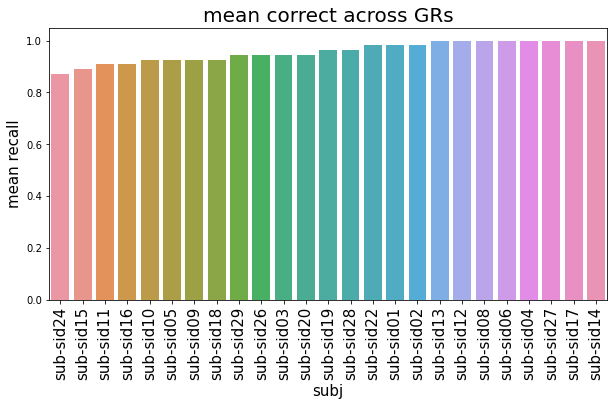

In [81]:
import seaborn as sns

df['cued_correct'] = df['cued_correct'].astype(np.float)
vals = df.groupby(["subj_idx", "subj"])["cued_correct"].describe()
vals = vals.sort_values("mean")

vals.reset_index(inplace=True)

plt.figure(figsize=(10,5))
sns.barplot(x='subj',y="mean", data=vals)
plt.xticks(rotation=90,fontsize=15)
plt.ylabel('mean recall', fontsize=15)
plt.xlabel('subj', fontsize=15)
plt.title("mean correct across GRs",fontsize=20);

print("% of subj with accuracy above 90% = {:.1f}%".format(np.sum(vals['mean']>.90)/len(vals['mean'])*100))
print("% of subj with accuracy 100% = {:.1f}%".format(np.sum(vals['mean']>=1.)/len(vals['mean'])*100))
print("lowest score = {:.1f}% | highest score = {:.1f}%".format(np.min(vals['mean'])*100, np.max(vals['mean'])*100))

% of subj with accuracy above 90% = 76.0%
% of subj with accuracy 100% = 44.0%
lowest score = 78.3% | highest score = 100.0%


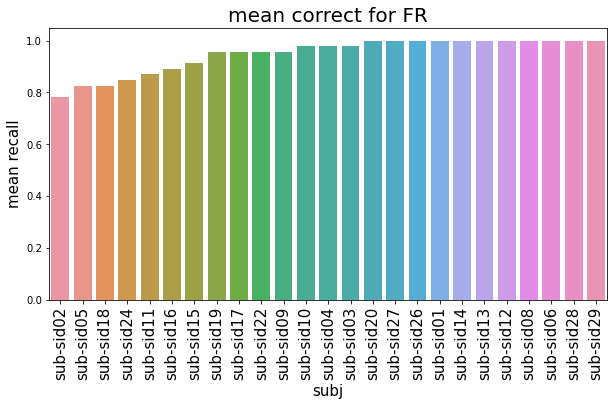

In [82]:
df['all_correct'] = df['all_correct'].astype(np.float)
FRdf = df[df.trial=='FR']

vals = FRdf.groupby(["subj_idx", "subj"])["all_correct"].describe()
vals = vals.sort_values("mean")

vals.reset_index(inplace=True)

plt.figure(figsize=(10,5))
sns.barplot(x='subj',y="mean", data=vals)
plt.xticks(rotation=90,fontsize=15)
plt.ylabel('mean recall', fontsize=15)
plt.xlabel('subj', fontsize=15)
plt.title("mean correct for FR",fontsize=20);

print("% of subj with accuracy above 90% = {:.1f}%".format(np.sum(vals['mean']>.90)/len(vals['mean'])*100))
print("% of subj with accuracy 100% = {:.1f}%".format(np.sum(vals['mean']>=1.)/len(vals['mean'])*100))
print("lowest score = {:.1f}% | highest score = {:.1f}%".format(np.min(vals['mean'])*100, np.max(vals['mean'])*100))

# time spent talking per trial

% change between first and last GR = -25.896%


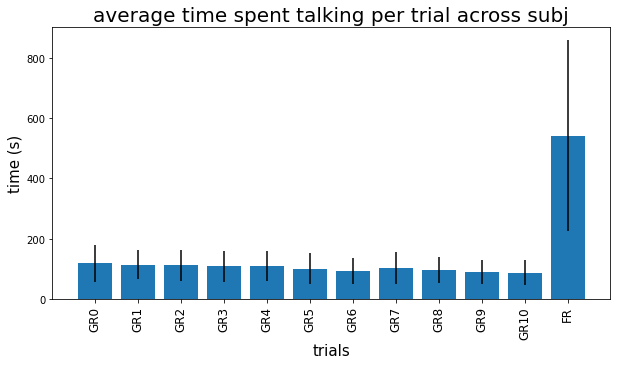

In [16]:

subj_times = np.full((nSubj, len(trials[:])), fill_value=0)
for s,subj in enumerate(subject_ids):
    for tr, trial in enumerate(trials[:]):
        times = df[(df.subj==subj)* (df.trial==trial)].trial_time.to_list()
        subj_times[s,tr] = times[0]
        
################
################

plt.figure(figsize=(10,5))
trial_mean = subj_times[:,:].mean(0) #mean across subj
trial_var = subj_times[:,:].std(0) #std across subj
plt.bar(range(12),trial_mean,yerr=trial_var)
plt.xticks(range(12),trials,rotation=90,fontsize=12);
plt.xlabel("trials",fontsize=15)
plt.ylabel("time (s)", fontsize=15)
plt.title("average time spent talking per trial across subj", fontsize=20)

print("% change between first and last GR = {:.3f}%".format(100*(trial_mean[-2]-trial_mean[0])/trial_mean[0]))

################
################




# time spent talking about rooms and objects

In [61]:

room_times = np.zeros((23))
object_times = np.zeros(23)

subj_room_times = {}
subj_obj_raw_times = {}
# for recalltype in ['rooms','objects']:

subj_room_times = np.full((nSubj, len(trials[:]), 23), fill_value=0)
subj_obj_raw_times = np.full((nSubj, len(trials[:]), 23), fill_value=0)

# for every subject look at the trials and extract the time talking about rooms / objects
for s,subj in enumerate(subject_ids):
    for tr, trial in enumerate(trials[:]):
        time_rooms = df[(df.subj==subj)* (df.trial==trial)].time_rooms.to_list()[0][0]
        time_objects_raw = df[(df.subj==subj)* (df.trial==trial)].time_raw_objects.to_list()[0][0]

#         print(time_rooms)

        ## fill info out into subjtimes
        for room_idx,obj_idx in zip(time_rooms.keys(),time_objects_raw.keys()):
            subj_room_times[s,tr,room_idx] = time_rooms[room_idx]
            subj_obj_raw_times[s,tr,obj_idx] = time_objects_raw[obj_idx]



/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [41]:
subj_room_times[:,:-1,:].sum(1)

array([[ 25,  15,  25,  34,  37,   6,  47,  23,  31,  20,   5,   6,  16,
          4,  27,  47,  20,  34,  43,  20,  26,  22,   5],
       [ 14,  30,  28,  53,  67,  31,  46,  34,  36,  51,  37,  68,  27,
         44,  71,  42,  28,  27,  73,  45,  44,  42,  45],
       [ 19,  23,  37,  55,  60,  47,  61,  28,  70,  59,   5,  66,   9,
         24,  61,  38,  19,  48,  55,  32,  26,  38,  88],
       [ 22,  25,  64,  54,  75,  29,  89,  58, 120,  59,  32,  64,   6,
         37,  63,  26,  27,  37,  94,  59,  57,  48,  79],
       [ 10,  11,  14,  14,  27,  14,   3,   3,  20,  32,   9,  32,   2,
         18,  13,   3,  16,  18,  21,  11,  17,  15,  20],
       [ 21,  19,  23,  40,  40,  36,  41,  25,  29,  76,  22,  44,  12,
         21,  37,  53,  28,  26,  51,  32,  25,  41,  68],
       [ 14,  31,  22,  25,  40,  17,  33,  21,  26,  36,  32,  37,   2,
         21,  54,  25,  25,  27,  55,  22,  28,  26,  44],
       [ 21,  26,  48,  51,  90, 103,  77,  56,  62,  58,  51,  53,  24,
   

Text(0.5, 1.0, 'time spent talking about object in GRs across all subj')

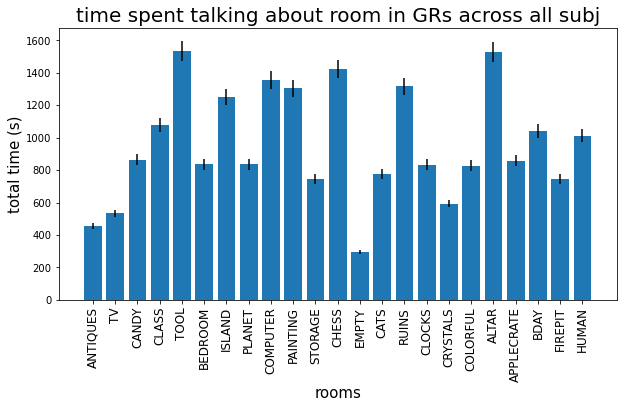

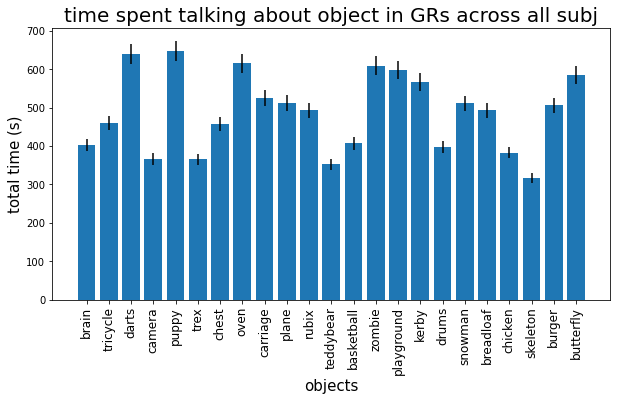

In [60]:

room_obj_names = dict(map(reversed, RoomObjectFileNameKey.items()))
room_names = [room_obj_names[i+1] for i in range(23)]
obj_names = [room_obj_names[i+23+1].split('.')[0] for i in range(23)]

################
################

plt.figure(figsize=(10,5))
room_sum = subj_room_times[:,:-1,:].sum(1).sum(0) #sum across trials, then sum across subj
room_var = subj_room_times[:,:-1,:].sum(1).mean(0) #sum across trials, mean across subj

# room_sum = subj_room_times[:,:-1,:].mean(1).mean(0) #mean across trials, then mean across subj
# room_var = subj_room_times[:,:-1,:].mean(1).std(0) #mean across trials, std across subj


plt.bar(range(23),room_sum,yerr=room_var)
# plt.errorbar(range(23), room_sum, xerr=0.2, yerr=0.4)
plt.xticks(range(23),room_names,rotation=90,fontsize=12);
plt.xlabel("rooms",fontsize=15)
plt.ylabel("total time (s)", fontsize=15)
plt.title("time spent talking about room in GRs across all subj", fontsize=20)


################
################

plt.figure(figsize=(10,5))
object_sum = subj_obj_raw_times[:,:-1,:].sum(1).sum(0) #sum across trials, then sum across subj
object_var = subj_obj_raw_times[:,:-1,:].sum(1).mean(0) #sum across trials, mean across subj

# object_sum = subj_obj_raw_times[:,:-1,:].mean(1).mean(0) #mean across trials, then mean across subj
# object_var = subj_obj_raw_times[:,:-1,:].mean(1).std(0) #mean across trials, std across subj

plt.bar(range(23),object_sum,yerr=object_var)
# plt.errorbar(range(23), object_sum, xerr=0.2, yerr=0.4)
plt.xticks(range(23),obj_names,rotation=90,fontsize=12);
plt.xlabel("objects",fontsize=15)
plt.ylabel("total time (s)", fontsize=15)
plt.title("time spent talking about object in GRs across all subj", fontsize=20)

# plt.figure()
# plt.bar(range(23),subj_times['objects'].mean(0))
# plt.xticks(range(23),obj_names,rotation=90);

### FIND OUT IF SUBJECTS THAT TALKED A LOT (trial time) correlates with a lot of time spent talking about a particular room?



Text(0.5, 1.0, 'time spent talking about object in FRs across all subj')

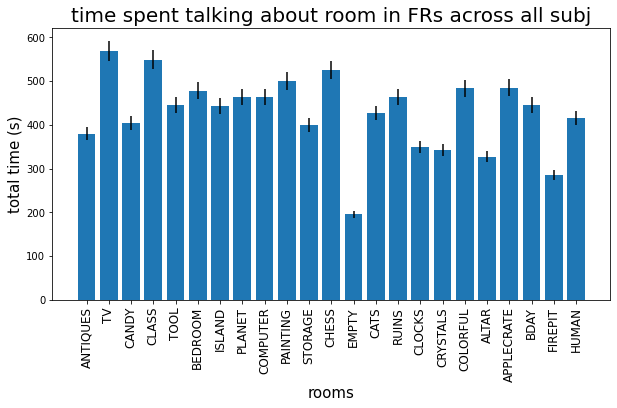

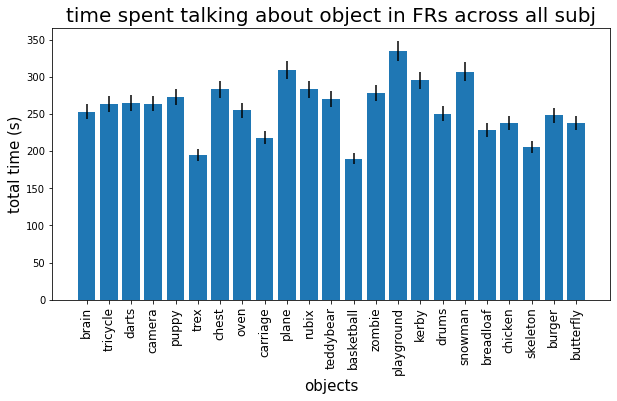

In [42]:

room_obj_names = dict(map(reversed, RoomObjectFileNameKey.items()))
room_names = [room_obj_names[i+1] for i in range(23)]
obj_names = [room_obj_names[i+23+1].split('.')[0] for i in range(23)]

################
################

plt.figure(figsize=(10,5))
room_sum = subj_room_times[:,-1:,:].sum(1).sum(0) #sum across trials, then sum across subj
room_var = subj_room_times[:,-1:,:].sum(1).mean(0) #sum across trials, mean across subj

plt.bar(range(23),room_sum,yerr=room_var)
# plt.errorbar(range(23), room_sum, xerr=0.2, yerr=0.4)
plt.xticks(range(23),room_names,rotation=90,fontsize=12);
plt.xlabel("rooms",fontsize=15)
plt.ylabel("total time (s)", fontsize=15)
plt.title("time spent talking about room in FRs across all subj", fontsize=20)


################
################

plt.figure(figsize=(10,5))
object_sum = subj_obj_raw_times[:,-1:,:].sum(1).sum(0) #sum across trials, then sum across subj
object_var = subj_obj_raw_times[:,-1:,:].sum(1).mean(0) #sum across trials, mean across subj

plt.bar(range(23),object_sum,yerr=object_var)
# plt.errorbar(range(23), object_sum, xerr=0.2, yerr=0.4)
plt.xticks(range(23),obj_names,rotation=90,fontsize=12);
plt.xlabel("objects",fontsize=15)
plt.ylabel("total time (s)", fontsize=15)
plt.title("time spent talking about object in FRs across all subj", fontsize=20)

# plt.figure()
# plt.bar(range(23),subj_times['objects'].mean(0))
# plt.xticks(range(23),obj_names,rotation=90);

### FIND OUT IF SUBJECTS THAT TALKED A LOT (trial time) correlates with a lot of time spent talking about a particular room?



# trajectories

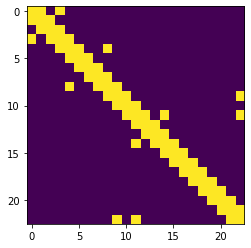

In [46]:
from _mempal_util import adj_mat, g
plt.imshow(adj_mat) # also adj_noself

In [62]:
path

array([10,  4,  6,  7, 17, 21, 19, 22, 13, 18,  1, 12, 20,  5,  2, 14,  9,
        3, 16, 15])

In [72]:

jumps = np.zeros((nSubj))

for s, subj in enumerate(subject_ids):
    total_traversals = 0
    valid_traversals = 0
    
    path = FRdf[FRdf.subj==subj].rooms_recalled.to_list()[0]
    
    for ni in range(len(path)-1):
        source = path[ni]
        target = path[ni+1]
        
        shortest_path = nx.shortest_path(g,source,target)
        
        # if shortest_path == 0, then it's a self loop. (don't count self-loops)
        if len(shortest_path)>1:
            # this only adds 1 from source to target, regardless of how many steps to get to target
            # in other words, this just counts the number of transitions, not shortest path length for each transition
            total_traversals += 1 
            
        # if shortest_path == 2, then it's truly an adjacent traversal
        if len(shortest_path)==2:
            valid_traversals+=1
                    
    jumps[s] = valid_traversals/total_traversals
        
        
    
#     print()



Text(0.5, 1.0, 'valid traversal during FR')

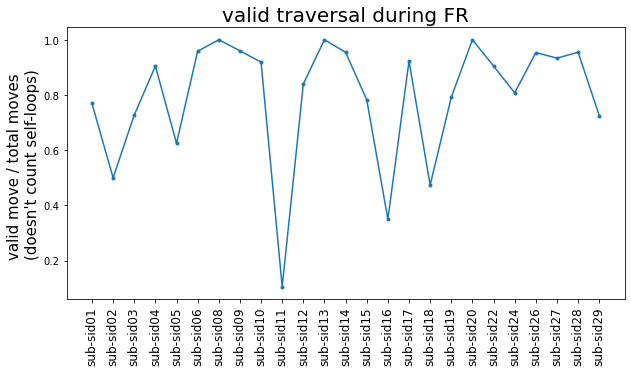

In [73]:
plt.figure(figsize=(10,5))
plt.plot(jumps,'.-')
plt.xticks(range(nSubj),subject_ids,rotation=90,fontsize=12);
plt.ylabel("valid move / total moves \n(doesn't count self-loops)",fontsize=15)
plt.title("valid traversal during FR",fontsize=20)

Text(0.5, 0, '% of valid traversal')

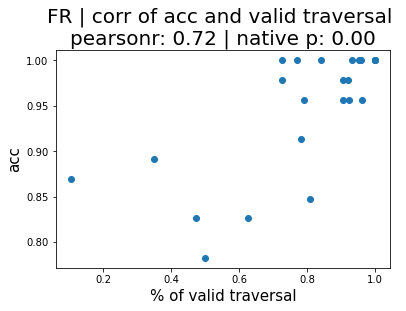

In [49]:
df['all_correct'] = df['all_correct'].astype(np.float)
FRdf = df[df.trial_type=='FR']

acc = FRdf.groupby(["subj_idx", "subj"])["all_correct"].describe()
# acc = acc.sort_values("mean")
acc.reset_index(inplace=True)

corr,p = stats.pearsonr(jumps,acc['mean'])

plt.scatter(jumps,acc['mean'])
plt.title('FR | corr of acc and valid traversal \npearsonr: {:.2f} | native p: {:.2f}'.format(corr,p),fontsize=20)
plt.ylabel("acc",fontsize=15)
plt.xlabel("% of valid traversal",fontsize=15)

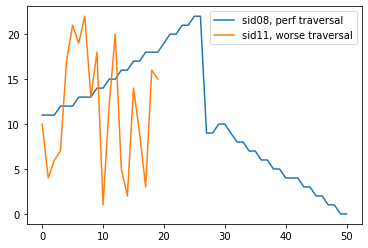

In [50]:
plt.plot(FRdf[FRdf.subj=='sub-sid08'].rooms_recalled.to_list()[0],label='sid08, perf traversal')
plt.plot(FRdf[FRdf.subj=='sub-sid11'].rooms_recalled.to_list()[0],label='sid11, worse traversal')
plt.legend()

# generate gif

Folder already exists: traversal_GIF
[10, 9, 8, 4]
False


/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  del sys.path[0]
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  
/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be a

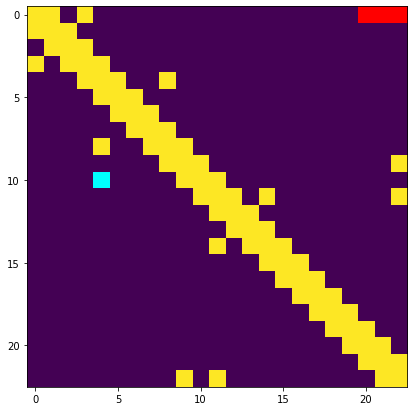

[4, 5, 6]
False


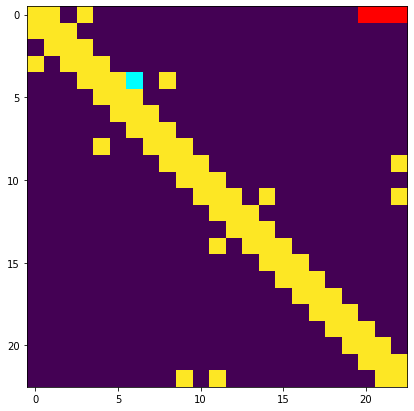

[6, 7]
True


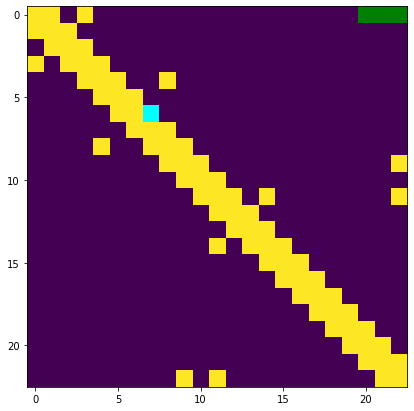

[7, 8, 9, 10, 11, 14, 15, 16, 17]
False


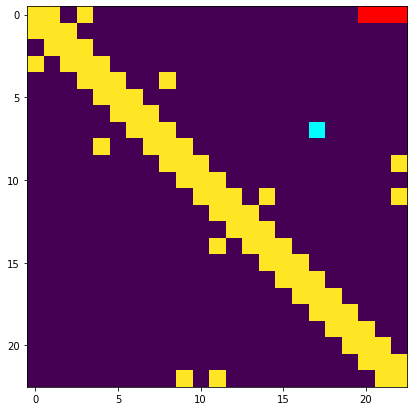

[17, 18, 19, 20, 21]
False


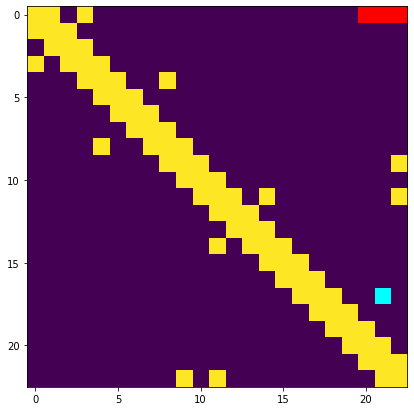

[21, 20, 19]
False


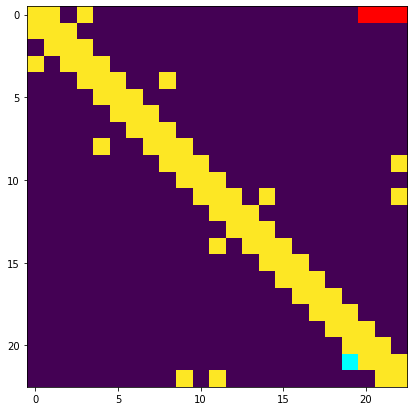

[19, 20, 21, 22]
False


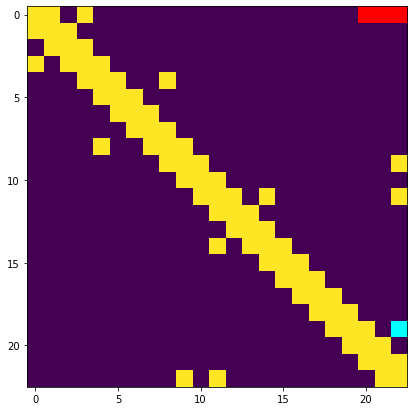

[22, 11, 12, 13]
False


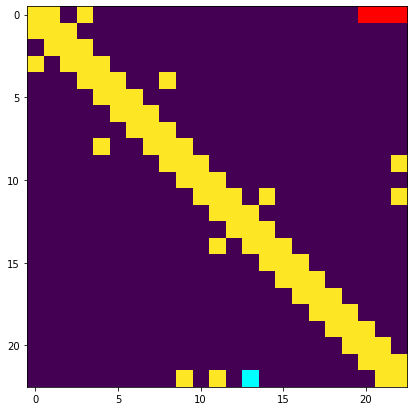

[13, 14, 15, 16, 17, 18]
False


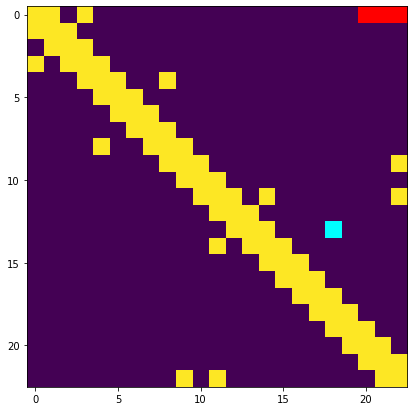

[18, 19, 20, 21, 22, 9, 8, 4, 3, 0, 1]
False


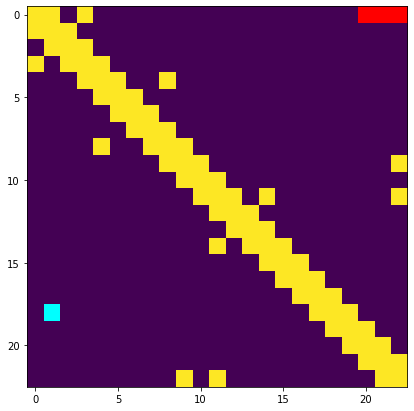

[1, 0, 3, 4, 8, 9, 10, 11, 12]
False


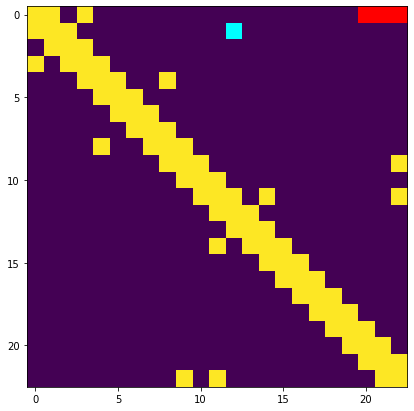

[12, 11, 22, 21, 20]
False


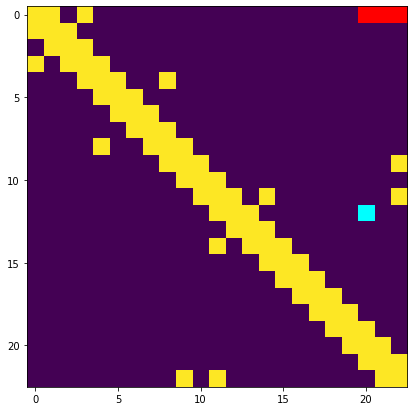

[20, 21, 22, 9, 8, 4, 5]
False


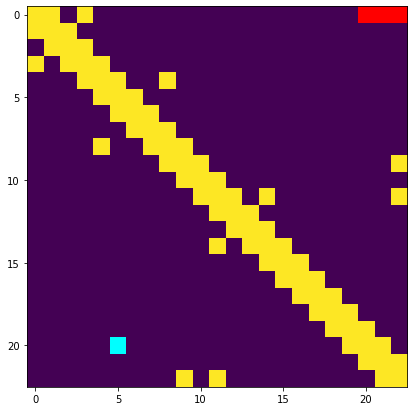

[5, 4, 3, 2]
False


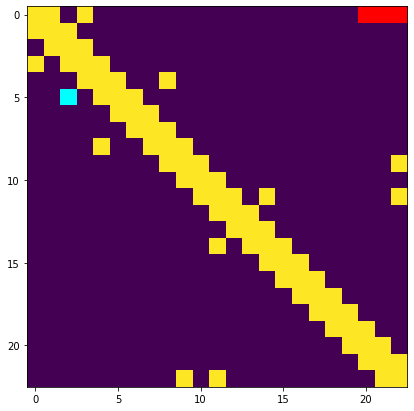

[2, 3, 4, 8, 9, 10, 11, 14]
False


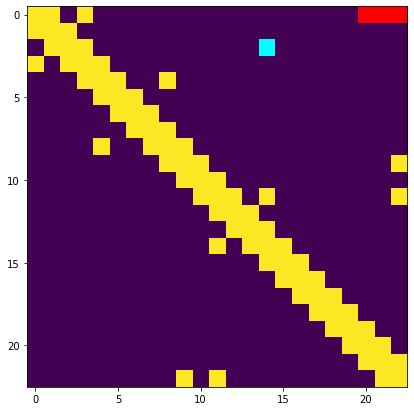

[14, 11, 10, 9]
False


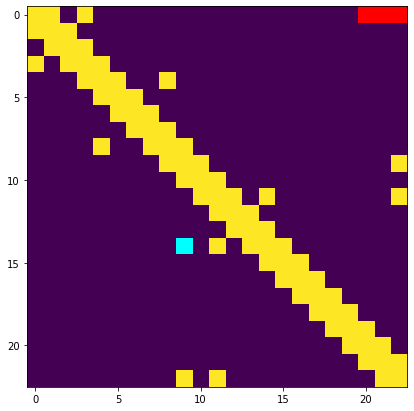

[9, 8, 4, 3]
False


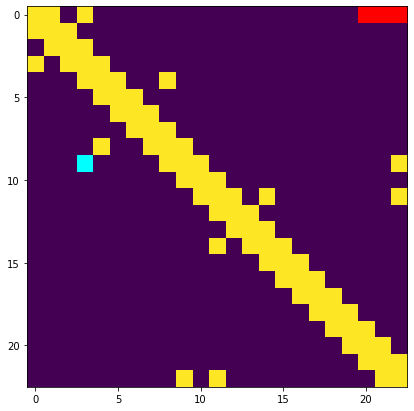

[3, 4, 8, 9, 10, 11, 14, 15, 16]
False


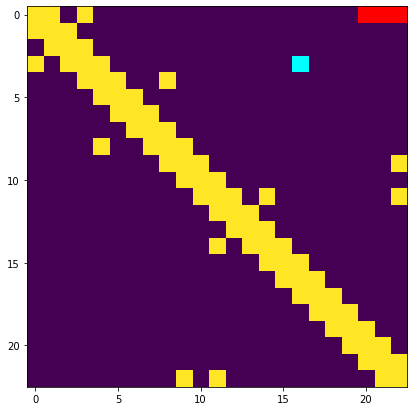

[16, 15]
True


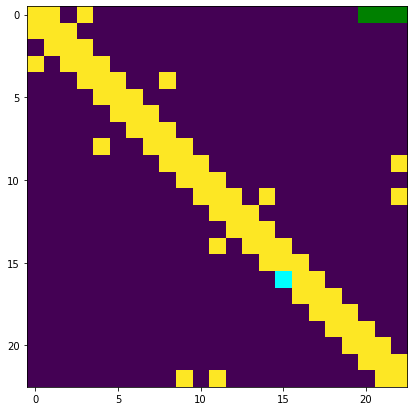


GIF created.


In [59]:
import matplotlib.cm as cm
from _mempal_util import GenerateGIF

gifdir = 'traversal_GIF'; create_dirs(gifdir);

def UpdatePlot(mat,row,col,valid,subj,idx, gifdir=gifdir):
    
    mat = mat.astype(float)
    
    plt.figure(figsize=(7,7))
    
    c_map = cm.get_cmap('viridis')
    c_map.set_bad('cyan')
    c_map.set_over(color='green', alpha=None)
    c_map.set_under(color='red',alpha=None)

    
    mat[row,col] = np.nan
    
    if valid:
        mat[0,20:23] = 1000000 # value that is over
    elif not valid:
        mat[0,20:23] = -100000 # vavld that is under
    
    plt.imshow(mat,c_map, vmin=0, vmax=1)
    plt.savefig(os.path.join(gifdir,'{}-{:02d}.png'.format(subj,idx)))#save

    plt.show()

    

for subj in ['sub-sid11']:#,'sub-sid11']

    
    path = FRdf[FRdf.subj==subj].rooms_recalled.to_list()[0]
    
    for ni in range(len(path)-1):
        valid = None
        source = path[ni]
        target = path[ni+1]
        
        shortest_path = nx.shortest_path(g,source,target)
        print(shortest_path)
        
        if len(shortest_path)==1:
            valid=True
            
        if len(shortest_path)==2:
            valid=True
        
        if len(shortest_path)>2:
            valid=False
            
        print(valid)
        UpdatePlot(adj_mat,source,target,valid,subj,ni)

    print()

plt.close('all')

## generate
GenerateGIF(os.path.join(gifdir,'{}-*.png'.format(subj)), "{}_FR_traversal.gif".format(subj))


GIF created.
